### Imports

In [3]:
import importlib
from matplotlib.pyplot import figure
from AIBind.import_modules import *
from AIBind import AIBind

In [4]:
importlib.reload(AIBind)

<module 'AIBind.AIBind' from '/home/sars-busters-consolidated/GitCode/AIBind/AIBind.py'>

### GPU Settings

In [5]:
str(subprocess.check_output('nvidia-smi', shell = True)).split('\\n')

["b'Mon Jul 19 18:27:47 2021       ",
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|===============================+======================+======================|',
 '|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |',
 '| N/A   72C    P0    34W /  70W |      0MiB / 15079MiB |      0%      Default |',
 '+-------------------------------+----------------------+----------------------+',
 '|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |',
 '| N/A   77C    P0    33W /  70W |    529MiB / 15079MiB |      0%      Default |',
 '+-------------------------------+---

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### VecNet Object

In [7]:
# Read In drugs and targets dataframes to pass to AIBind after changing column names 
with open('/data/sars-busters/Mol2Vec/chemicals_01_w_embed.pkl', 'rb') as file: 
    drugs = pkl.load(file)
    
with open('/data/sars-busters/Mol2Vec/amino_01_w_embed.pkl', 'rb') as file: 
    targets = pkl.load(file)

# Ensure correct column names    
drugs = drugs.rename(columns = {'Label' : 'InChiKey'})
targets = targets.rename(columns = {'Label' : 'target_aa_code'})

In [8]:
## Generated once and used across all models

targets_test = []
targets_validation = []
edges_test = []
edges_validation = []
train_sets = []

for run_number in tqdm(range(5)):
    
    targets_test.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/test_unseen_nodes_' + str(run_number) + '.csv'))
    edges_test.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/test_unseen_edges_' + str(run_number) + '.csv'))    
    targets_validation.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/validation_unseen_nodes_' + str(run_number) + '.csv'))    
    edges_validation.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/validation_unseen_edges_' + str(run_number) + '.csv'))    
    train_sets.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/train_' + str(run_number) + '.csv'))    

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
np.random.seed(2021)

random_targets = []
for idx, rows in tqdm(targets.iterrows()):
    random_targets.append([rows['target_aa_code'], np.random.uniform(-1, 1, (100,))])

random_targets = pd.DataFrame(random_targets)
random_targets.columns = ['target_aa_code', 'normalized_embeddings']
random_targets

# random_drugs = []
# for idx, rows in tqdm(drugs.iterrows()):
#     random_drugs.append([rows['InChiKey'], np.random.uniform(-1, 1, (300,))])

# random_drugs = pd.DataFrame(random_drugs)
# random_drugs.columns = ['InChiKey', 'normalized_embeddings']
# random_drugs

0it [00:00, ?it/s]

target_aa_code  \
0     MEVKVGLAPMAGYTDSAFRTLAFEWGADFAFSEMVSAKGFLMNSQK...   
1     MACLLRSFQRISAGVFFLALWGMVVGDKLLVVPQDGSHWLSMKDIV...   
2     MHKAGLLGLCARAWNSVRMASSGMTRRDPLANKVALVTASTDGIGF...   
3     MERNKLARQIIDTCLEMTRLGLNQGTAGNVSVRYQDGMLITPTGIP...   
4     MRPPWYPLHTPSLASPLLFLLLSLLGGGARAEGREDPQLLVRVRGG...   
...                                                 ...   
5099  MANVDEAILKRVKGWAPYVDAKLGFRNHWYPVMFSKEINEGEPKTL...   
5100  MSGTRASNDRPPGAGGVKRGRLQQEAAATGSRVTVVLGAQWGDEGK...   
5101  MTHQDLSITAKLINGGVAGLVGVTCVFPIDLAKTRLQNQHGKAMYK...   
5102  MAASGEGVSLPSPAGGEDAHRRRVSYFYEPSIGDYYYGQGHPMKPH...   
5103  MGSNLSPQLCLMPFILGLLSGGVTTTPWSLARPQGSCSLEGVEIKG...   

                                  normalized_embeddings  
0     [0.21195655761480947, 0.4667387223869963, -0.7...  
1     [-0.7523200864398463, 0.960241716146321, -0.09...  
2     [-0.9825585995887249, -0.6637208111430337, -0....  
3     [-0.6015426454014048, -0.6468386068770147, -0....  
4     [-0.5032155927365585, -0.3777631788592155, 0.4...  
...                                                 ...  
5099  [0.4460690131284204, -0.2688807195866556, 0.64...  
5100  [-0.8813775603676377, 0.9232424478410162, 0.36...  
5101  [0.1588354930483058, 0.5559009392941205, -0.12...  
5102  [0.405797146796788, 0.2503201042813241, -0.961...  
5103  [0.7831162844519146, 0.36466621617247763, 0.87...  

[5104 rows x 2 columns]

In [11]:
# Create object
vecnet_object = AIBind.AIBind(interactions_location = '/data/sars-busters-consolidated/GitData/interactions/Network_Derived_Negatives.csv',
                              interactions = None,
                              interaction_y_name = 'Y',

                              absolute_negatives_location = None,
                              absolute_negatives = None,

                              drugs_location = None,
                              drugs_dataframe = drugs,
                              drug_inchi_name = 'InChiKey',
                              drug_smile_name = 'SMILE',

                              targets_location = None,
                              targets_dataframe = random_targets, 
                              target_seq_name = 'target_aa_code',

                              mol2vec_location = None,
                              mol2vec_model = None,

                              protvec_location = None,
                              protvec_model = None,

                              nodes_test = targets_test, 
                              nodes_validation = targets_validation, 

                              edges_test = edges_test, 
                              edges_validation = edges_validation,  

                              model_out_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Random-TR',

                              debug = False)

### Training and Testing VecNet

#### Update Embeddings

In [12]:
vecnet_object.get_external_drug_embeddings(pred_drug_embeddings = None,
                                           normalized = False,
                                           replace_dataframe = True,
                                           return_normalisation_conststants = False)
vecnet_object.get_external_target_embeddings(pred_target_embeddings = None,
                                             normalized = False,
                                             replace_dataframe = True,
                                             return_normalisation_conststants = False)

In [13]:
vecnet_object.create_train_sets(unseen_nodes_flag = True, ## Unseen nodes for True, unseen targets for False
                                data_leak_check = True)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Set :  0
Train - Test - Validation Overlap For Unseen Targets :  0
Train - Test - Validation Overlap For Unseen Drugs :  0
Train - Test - Validation Overlap For Unseen Edges :  0
Train Set :  (12770, 3)
Nodes Test :  (6491, 3)
Nodes Val :  (6492, 3)
Edge Test :  (3693, 3)
Edge Val :  (3693, 3)
Positive / Negatative Ratio :  0.37341363734136374

Set :  1
Train - Test - Validation Overlap For Unseen Targets :  0
Train - Test - Validation Overlap For Unseen Drugs :  0
Train - Test - Validation Overlap For Unseen Edges :  0
Train Set :  (12166, 3)
Nodes Test :  (6935, 3)
Nodes Val :  (6790, 3)
Edge Test :  (3603, 3)
Edge Val :  (3603, 3)
Positive / Negatative Ratio :  0.3620689655172414

Set :  2
Train - Test - Validation Overlap For Unseen Targets :  0
Train - Test - Validation Overlap For Unseen Drugs :  0
Train - Test - Validation Overlap For Unseen Edges :  0
Train Set :  (15660, 3)
Nodes Test :  (6329, 3)
Nodes Val :  (6184, 3)
Edge Test :  (3785, 3)
Edge Val :  (3785, 3)
Positive / N

#### Train Model

In [14]:
vecnet_object.train_vecnet(model_name = 'vecnet_random_5_fold_unseen_nodes',
                           epochs = 20,
                           version = 0,
                           learning_rate = 0.00001,
                           beta_1 = 0.9,
                           beta_2 = 0.999,
                           batch_size = 16,
                           chunk_test_frequency = 250)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Unseen Nodes AUC : 0.41
Unseen Edges AUC : 0.46
Unseen Nodes AUP : 0.43
Unseen Edges AUP : 0.51

Unseen Nodes AUC : 0.55
Unseen Edges AUC : 0.54
Unseen Nodes AUP : 0.49
Unseen Edges AUP : 0.54

Unseen Nodes AUC : 0.51
Unseen Edges AUC : 0.53
Unseen Nodes AUP : 0.47
Unseen Edges AUP : 0.54

Unseen Nodes AUC : 0.49
Unseen Edges AUC : 0.54
Unseen Nodes AUP : 0.46
Unseen Edges AUP : 0.56

Unseen Nodes AUC : 0.47
Unseen Edges AUC : 0.55
Unseen Nodes AUP : 0.45
Unseen Edges AUP : 0.58

Unseen Nodes AUC : 0.46
Unseen Edges AUC : 0.56
Unseen Nodes AUP : 0.44
Unseen Edges AUP : 0.6

Unseen Nodes AUC : 0.46
Unseen Edges AUC : 0.57
Unseen Nodes AUP : 0.44
Unseen Edges AUP : 0.61

Unseen Nodes AUC : 0.46
Unseen Edges AUC : 0.58
Unseen Nodes AUP : 0.44
Unseen Edges AUP : 0.63

Unseen Nodes AUC : 0.47
Unseen Edges AUC : 0.59
Unseen Nodes AUP : 0.44
Unseen Edges AUP : 0.64

Unseen Nodes AUC : 0.47
Unseen Edges AUC : 0.6
Unseen Nodes AUP : 0.44
Unseen Edges AUP : 0.65

Unseen Nodes AUC : 0.48
Unseen E

  0%|          | 0/20 [00:00<?, ?it/s]

Unseen Nodes AUC : 0.42
Unseen Edges AUC : 0.47
Unseen Nodes AUP : 0.47
Unseen Edges AUP : 0.51

Unseen Nodes AUC : 0.56
Unseen Edges AUC : 0.52
Unseen Nodes AUP : 0.54
Unseen Edges AUP : 0.5

Unseen Nodes AUC : 0.53
Unseen Edges AUC : 0.5
Unseen Nodes AUP : 0.53
Unseen Edges AUP : 0.49

Unseen Nodes AUC : 0.51
Unseen Edges AUC : 0.49
Unseen Nodes AUP : 0.52
Unseen Edges AUP : 0.5

Unseen Nodes AUC : 0.49
Unseen Edges AUC : 0.5
Unseen Nodes AUP : 0.51
Unseen Edges AUP : 0.51

Unseen Nodes AUC : 0.47
Unseen Edges AUC : 0.5
Unseen Nodes AUP : 0.5
Unseen Edges AUP : 0.52

Unseen Nodes AUC : 0.46
Unseen Edges AUC : 0.52
Unseen Nodes AUP : 0.49
Unseen Edges AUP : 0.54

Unseen Nodes AUC : 0.46
Unseen Edges AUC : 0.53
Unseen Nodes AUP : 0.48
Unseen Edges AUP : 0.55

Unseen Nodes AUC : 0.46
Unseen Edges AUC : 0.54
Unseen Nodes AUP : 0.47
Unseen Edges AUP : 0.56

Unseen Nodes AUC : 0.45
Unseen Edges AUC : 0.55
Unseen Nodes AUP : 0.47
Unseen Edges AUP : 0.57

Unseen Nodes AUC : 0.45
Unseen Edges

  0%|          | 0/20 [00:00<?, ?it/s]

Unseen Nodes AUC : 0.43
Unseen Edges AUC : 0.4
Unseen Nodes AUP : 0.42
Unseen Edges AUP : 0.45

Unseen Nodes AUC : 0.55
Unseen Edges AUC : 0.54
Unseen Nodes AUP : 0.47
Unseen Edges AUP : 0.51

Unseen Nodes AUC : 0.53
Unseen Edges AUC : 0.54
Unseen Nodes AUP : 0.46
Unseen Edges AUP : 0.52

Unseen Nodes AUC : 0.52
Unseen Edges AUC : 0.55
Unseen Nodes AUP : 0.46
Unseen Edges AUP : 0.54

Unseen Nodes AUC : 0.51
Unseen Edges AUC : 0.56
Unseen Nodes AUP : 0.46
Unseen Edges AUP : 0.56

Unseen Nodes AUC : 0.5
Unseen Edges AUC : 0.56
Unseen Nodes AUP : 0.46
Unseen Edges AUP : 0.58

Unseen Nodes AUC : 0.51
Unseen Edges AUC : 0.57
Unseen Nodes AUP : 0.47
Unseen Edges AUP : 0.6

Unseen Nodes AUC : 0.51
Unseen Edges AUC : 0.58
Unseen Nodes AUP : 0.47
Unseen Edges AUP : 0.61

Unseen Nodes AUC : 0.51
Unseen Edges AUC : 0.58
Unseen Nodes AUP : 0.47
Unseen Edges AUP : 0.61

Unseen Nodes AUC : 0.51
Unseen Edges AUC : 0.59
Unseen Nodes AUP : 0.47
Unseen Edges AUP : 0.62

Unseen Nodes AUC : 0.51
Unseen Ed

  0%|          | 0/20 [00:00<?, ?it/s]

Unseen Nodes AUC : 0.45
Unseen Edges AUC : 0.42
Unseen Nodes AUP : 0.45
Unseen Edges AUP : 0.47

Unseen Nodes AUC : 0.54
Unseen Edges AUC : 0.57
Unseen Nodes AUP : 0.48
Unseen Edges AUP : 0.54

Unseen Nodes AUC : 0.53
Unseen Edges AUC : 0.58
Unseen Nodes AUP : 0.48
Unseen Edges AUP : 0.55

Unseen Nodes AUC : 0.53
Unseen Edges AUC : 0.59
Unseen Nodes AUP : 0.48
Unseen Edges AUP : 0.58

Unseen Nodes AUC : 0.53
Unseen Edges AUC : 0.59
Unseen Nodes AUP : 0.49
Unseen Edges AUP : 0.59

Unseen Nodes AUC : 0.53
Unseen Edges AUC : 0.6
Unseen Nodes AUP : 0.49
Unseen Edges AUP : 0.6

Unseen Nodes AUC : 0.52
Unseen Edges AUC : 0.59
Unseen Nodes AUP : 0.49
Unseen Edges AUP : 0.61

Unseen Nodes AUC : 0.53
Unseen Edges AUC : 0.6
Unseen Nodes AUP : 0.49
Unseen Edges AUP : 0.61

Unseen Nodes AUC : 0.52
Unseen Edges AUC : 0.59
Unseen Nodes AUP : 0.49
Unseen Edges AUP : 0.62

Unseen Nodes AUC : 0.52
Unseen Edges AUC : 0.6
Unseen Nodes AUP : 0.5
Unseen Edges AUP : 0.62

Unseen Nodes AUC : 0.53
Unseen Edge

  0%|          | 0/20 [00:00<?, ?it/s]

Unseen Nodes AUC : 0.41
Unseen Edges AUC : 0.43
Unseen Nodes AUP : 0.45
Unseen Edges AUP : 0.47

Unseen Nodes AUC : 0.56
Unseen Edges AUC : 0.54
Unseen Nodes AUP : 0.52
Unseen Edges AUP : 0.53

Unseen Nodes AUC : 0.5
Unseen Edges AUC : 0.51
Unseen Nodes AUP : 0.48
Unseen Edges AUP : 0.51

Unseen Nodes AUC : 0.46
Unseen Edges AUC : 0.51
Unseen Nodes AUP : 0.46
Unseen Edges AUP : 0.52

Unseen Nodes AUC : 0.44
Unseen Edges AUC : 0.51
Unseen Nodes AUP : 0.45
Unseen Edges AUP : 0.53

Unseen Nodes AUC : 0.44
Unseen Edges AUC : 0.52
Unseen Nodes AUP : 0.45
Unseen Edges AUP : 0.55

Unseen Nodes AUC : 0.44
Unseen Edges AUC : 0.54
Unseen Nodes AUP : 0.45
Unseen Edges AUP : 0.57

Unseen Nodes AUC : 0.45
Unseen Edges AUC : 0.56
Unseen Nodes AUP : 0.46
Unseen Edges AUP : 0.59

Unseen Nodes AUC : 0.46
Unseen Edges AUC : 0.57
Unseen Nodes AUP : 0.47
Unseen Edges AUP : 0.61

Unseen Nodes AUC : 0.46
Unseen Edges AUC : 0.58
Unseen Nodes AUP : 0.47
Unseen Edges AUP : 0.62

Unseen Nodes AUC : 0.46
Unseen 

#### Get Validation Results

In [15]:
vecnet_object.get_validation_results(model_name = None, 
                                    version_number = None,
                                    show_plots = True,
                                    plot_title = 'Validation Results - 5 Fold Cross Validation',
                                    num_cols = 2,
                                    plot_height = 1500,
                                    plot_width = 1500,
                                    write_plot_to_html = True,
                                    plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Random-TR',
                                    plot_name = 'Validation')

(Epoch * Chunk) With Highest Unseen Node and Edge Score :  1
(Epoch * Chunk) With Highest Unseen Node Score :  1
(Epoch * Chunk) With Highest Unseen Edge Score :  1
Validation Performance
Best Model Suffix :  _epoch_1_idx_0.model
Unseen Node AUC :  0.5508950917496062 +/- 0.00895820893530016
Unseen Node AUP :  0.5006605283410588 +/- 0.026121142207453974
Unseen Edges AUC :  0.5412884714218652 +/- 0.016621462193347647
Unseen Edges AUP :  0.5217667916106015 +/- 0.015237560617010096


#### Get Test Results

Testing on model :  vecnet_random_5_fold_unseen_nodes_v00_run0_07-19_18h29_epoch_1_idx_0.model
Testing on model :  vecnet_random_5_fold_unseen_nodes_v00_run1_07-19_18h32_epoch_1_idx_0.model
Testing on model :  vecnet_random_5_fold_unseen_nodes_v00_run2_07-19_18h35_epoch_1_idx_0.model
Testing on model :  vecnet_random_5_fold_unseen_nodes_v00_run3_07-19_18h38_epoch_1_idx_0.model
Testing on model :  vecnet_random_5_fold_unseen_nodes_v00_run4_07-19_18h41_epoch_1_idx_0.model


/home/sars-busters-consolidated/GitCode/AIBind/AIBind.py:1424: RuntimeWarning:

invalid value encountered in true_divide



Unseen Nodes / Targets     Unseen Edges
AUC                 0.558 +/- 0.009  0.555 +/- 0.014
AUP                 0.501 +/- 0.021  0.525 +/- 0.013
F1 Score            0.641 +/- 0.013  0.665 +/- 0.006
F1 Threshold        0.004 +/- 0.005      0.0 +/- 0.0

Confusion Matrix - Unseen Nodes / Targets : 


Pred (0)       Pred (1)
True (0)  0.74 +/- 0.01  0.52 +/- 0.01
True (1)  0.26 +/- 0.01  0.48 +/- 0.01

Confusion Matrix - Unseen Edges : 


Pred (0)     Pred (1)
True (0)  nan +/- nan  0.5 +/- 0.0
True (1)  nan +/- nan  0.5 +/- 0.0

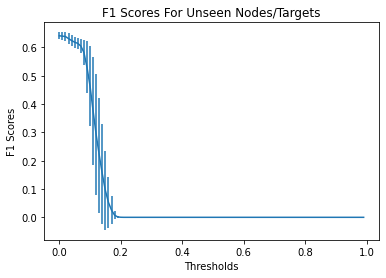

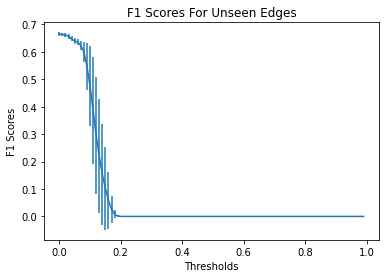

In [16]:
vecnet_object.get_test_results(model_name = None, 
                            version_number = None, 
                            optimal_validation_model = None, 
                            drug_filter_list = [], 
                            target_filter_list = targets['target_aa_code'].tolist(), 
                            write_plot_to_disk = True, 
                            plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Random-TR', 
                            plot_name = 'Test')

#### Stats on Test Results

In [19]:
test_preidcitons_5fold_average = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = vecnet_object.nodes_test,
                                                                                     get_drug_embed = False,
                                                                                     get_target_embed = False,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = targets['target_aa_code'].tolist(),
                                                                                     return_dataframes = True )


Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_0/vecnet_ds2_5_fold_unseen_nodes_v00_run0_07-13_19h11_epoch_19_idx_0.model
filtered_nodes_test :  (6491, 3)
Drugs :  3132
Targets :  907
pred_targets_dataframe :  (907, 2)
pred_drugs_dataframe :  (3124, 2)
X0, X1 :  (6491, 100) (6491, 300)
filtered_nodes_test :  (6900, 3)
Drugs :  3366
Targets :  947
pred_targets_dataframe :  (947, 2)
pred_drugs_dataframe :  (3340, 2)
X0, X1 :  (6900, 100) (6900, 300)
filtered_nodes_test :  (6293, 3)
Drugs :  2660
Targets :  988
pred_targets_dataframe :  (988, 2)
pred_drugs_dataframe :  (2631, 2)
X0, X1 :  (6293, 100) (6293, 300)
filtered_nodes_test :  (6539, 3)
Drugs :  3466
Targets :  956
pred_targets_dataframe :  (956, 2)
pred_drugs_dataframe :  (3431, 2)
X0, X1 :  (6539, 100) (6539, 300)
filtered_nodes_test :  (6594, 3)
Drugs :  2581
Targets :  997
pred_targets_dataframe :  (997, 2)
pred_drugs_dataframe :  (2545, 2)
X0, X1 :  (6594, 100) (6594, 300)
Testing on model :  /data

/home/sars-busters-consolidated/GitCode/AIBind/AIBind.py:1207: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
all_test = pd.concat([test_preidcitons_5fold_average[0],test_preidcitons_5fold_average[1],test_preidcitons_5fold_average[2],test_preidcitons_5fold_average[3],test_preidcitons_5fold_average[4]])

In [21]:
all_test['binary_Y'] = [1 if x > 0.086 else 0 for x in all_test['Averaged Predictions'].tolist()]

In [22]:
all_test_fp = all_test[(all_test.Y == 0) & (all_test.binary_Y == 1)]
all_test_tp = all_test[(all_test.Y == 1) & (all_test.binary_Y == 1)]
all_test_fn = all_test[(all_test.Y == 1) & (all_test.binary_Y == 0)]
all_test_tn = all_test[(all_test.Y == 0) & (all_test.binary_Y == 0)]

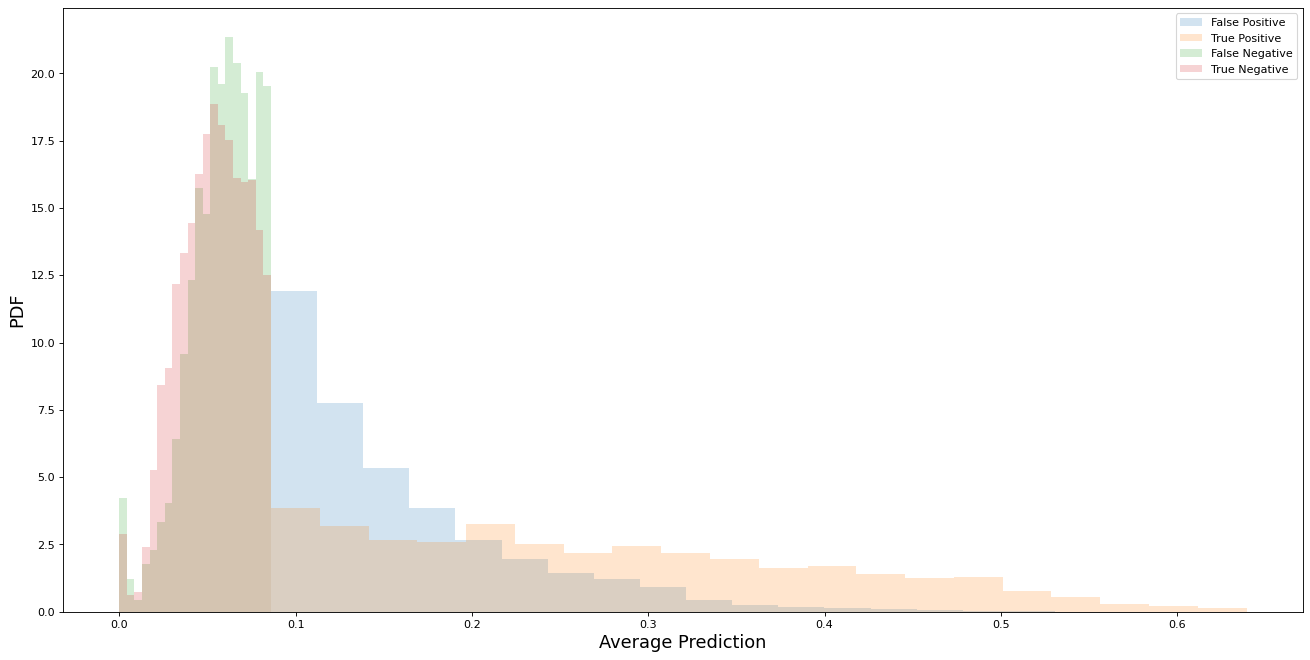

In [23]:
figure(figsize=(20, 10), dpi=80)
plt.hist(all_test_fp['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='False Positive')
plt.hist(all_test_tp['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='True Positive')
plt.hist(all_test_fn['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='False Negative')
plt.hist(all_test_tn['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='True Negative')
plt.legend()
plt.xlabel('Average Prediction',fontsize=16)
plt.ylabel('PDF',fontsize=16)
plt.show()

Text(0, 0.5, 'PDF')

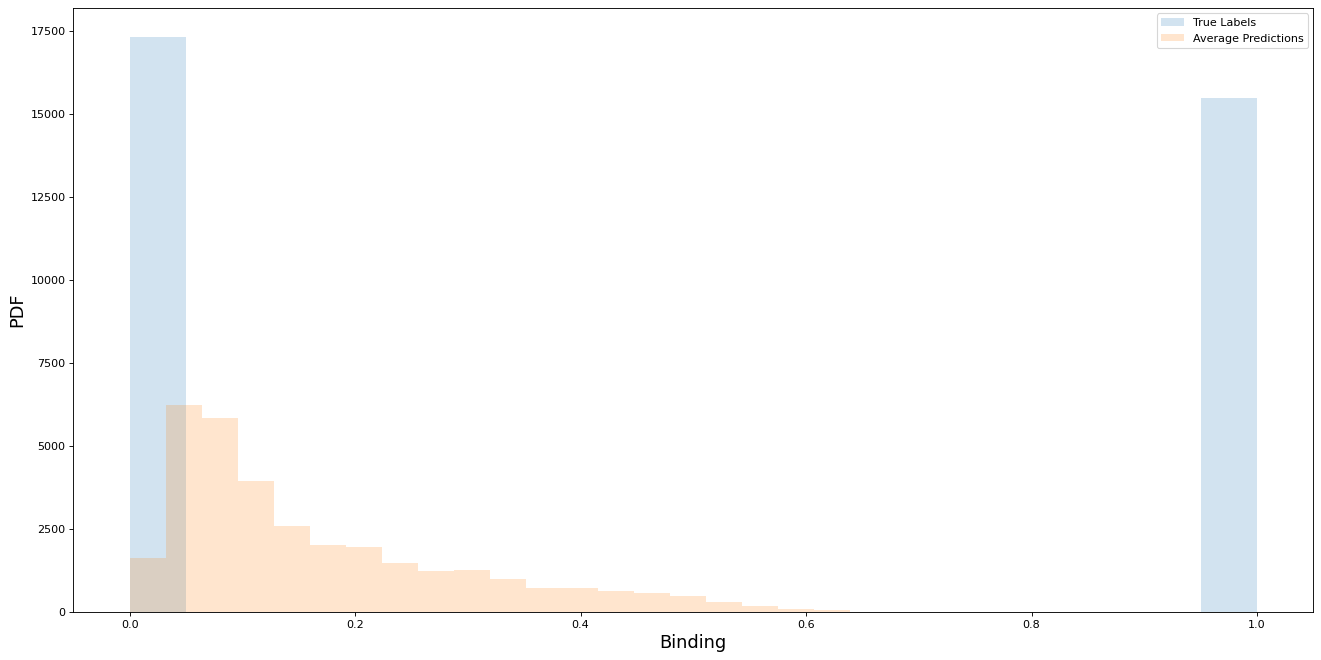

In [24]:
figure(figsize=(20, 10), dpi=80)
plt.hist(all_test['Y'],density=False,alpha=0.2,bins=20,label='True Labels')
plt.hist(all_test['Averaged Predictions'],density=False,alpha=0.2,bins=20,label='Average Predictions')
plt.legend()
plt.xlabel('Binding',fontsize=16)
plt.ylabel('PDF',fontsize=16)

Text(0, 0.5, 'PDF')

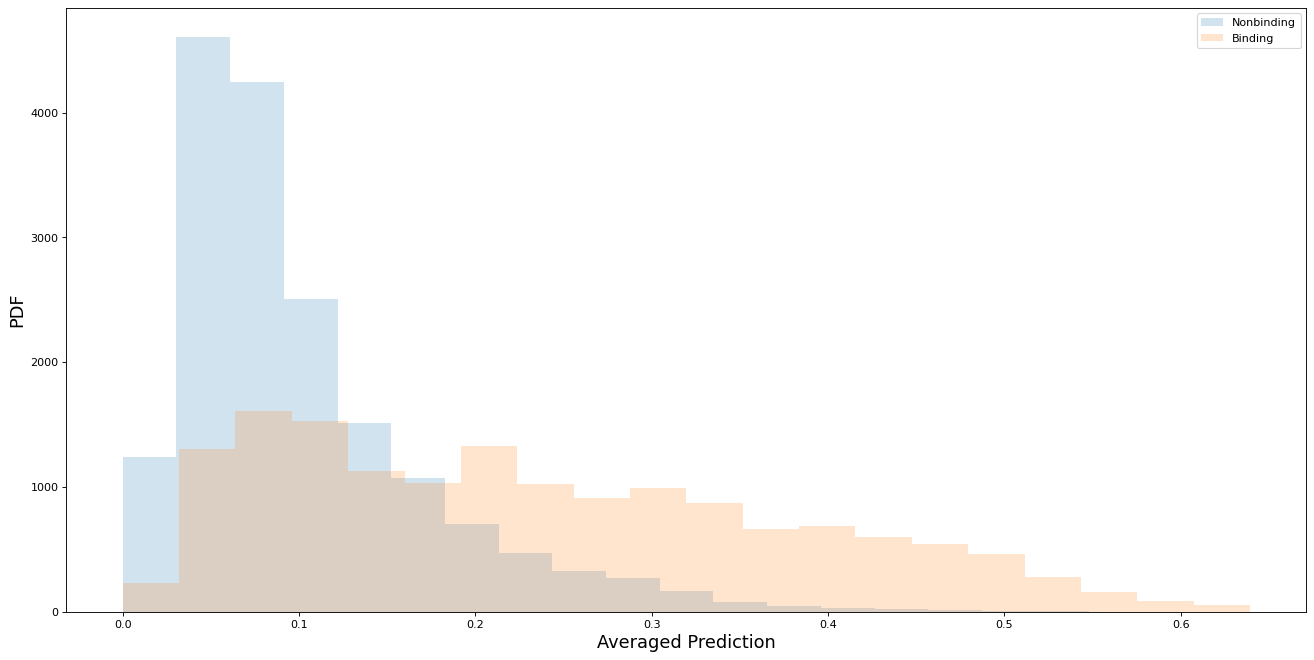

In [25]:
figure(figsize=(20, 10), dpi=80)
plt.hist(all_test[all_test['Y']==0]['Averaged Predictions'],density=False,alpha=0.2,bins=20,label='Nonbinding')
plt.hist(all_test[all_test['Y']==1]['Averaged Predictions'],density=False,alpha=0.2,bins=20,label='Binding')
plt.legend()
plt.xlabel('Averaged Prediction',fontsize=16)
plt.ylabel('PDF',fontsize=16)

In [26]:
len(set(all_test['target_aa_code'].tolist()))

4591

In [27]:
all_test

InChiKey  \
0     GYHCTFXIZSNGJT-XMMPIXPASA-N   
1     VSHUQLRHTJOKTA-XBXARRHUSA-N   
2     KKKRKRMVJRHDMG-UHFFFAOYSA-N   
3     WQZGKKKJIJFFOK-VFUOTHLCSA-N   
4     UTEAJHNFBCLZHN-UHFFFAOYSA-N   
...                           ...   
6617  KWIUHFFTVRNATP-UHFFFAOYSA-O   
6618  CNIIGCLFLJGOGP-UHFFFAOYSA-N   
6619  BJXLHKJBRORJJJ-UHFFFAOYSA-N   
6620  ROHFNLRQFUQHCH-YFKPBYRVSA-N   
6622  KGBXLFKZBHKPEV-UHFFFAOYSA-N   

                                         target_aa_code  Y  \
0     MLMASTTSAVPGHPSLPSLPSNSSQERPLDTRDPLLARAELALLSI...  1   
1     MALLEIIHYPSKILRTISKEVVSFDAKLHQQLDDMYETMIASEGIG...  1   
2     MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKT...  1   
3     MLKTKRKLTKAIGVALSISILSSLVSFIPQTNTYAAGTYNYGEALQ...  1   
4     MTPLCPRPALCYHFLTSLLRSAMQNARGARQRAEAAVLSGPGPPLG...  0   
...                                                 ... ..   
6617  MSTQRLRNEDYHDYSSTDVSPEESPSEGLNNLSSPGSYQRFGQSNS...  0   
6618  MSDSVILRSIKKFGEENDGFESDKSYNNDKKSRLQDEKKGDGVRVG...  0   
6619  MPEIVDTCSLASPASVCRTKHLHLRCSVDFTRRTLTGTAALTVQSQ...  0   
6620  MSTQRLRNEDYHDYSSTDVSPEESPSEGLNNLSSPGSYQRFGQSNS...  0   
6622  MKKLIFLIVIALVLSACNSNSSHAKELNDLEKKYNAHIGVYALDTK...  0   

      Averaged Predictions  binary_Y  
0                 0.068986         0  
1                 0.053989         0  
2                 0.116225         1  
3                 0.132609         1  
4                 0.042960         0  
...                    ...       ...  
6617              0.301762         1  
6618              0.286252         1  
6619              0.297886         1  
6620              0.288428         1  
6622              0.000144         0  

[32817 rows x 5 columns]

In [28]:
all_test.reset_index().to_csv('/data/sars-busters-consolidated/GitData/test_predictions_5_fold.csv')

#### Test performance for DrugBank and NDM

In [29]:
nodes_info = pd.read_csv('/data/sars-busters-consolidated/nw_files/WholeNetworkNodesTable.csv')

In [30]:
drug_InChIKeys = nodes_info[(nodes_info.Type == 'Chemical') & (nodes_info.IsDrug == True)]['Label'].tolist()
NDM_InChIKeys = nodes_info[(nodes_info.Type == 'Chemical') & (nodes_info.IsNDM == True)]['Label'].tolist()

Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run0_07-13_19h11_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run1_07-13_19h14_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run2_07-13_19h17_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run3_07-13_19h20_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run4_07-13_19h23_epoch_19_idx_0.model


Unseen Nodes / Targets     Unseen Edges
AUC                 0.738 +/- 0.034  0.789 +/- 0.008
AUP                 0.722 +/- 0.041   0.81 +/- 0.013
F1 Score            0.683 +/- 0.017   0.72 +/- 0.007
F1 Threshold          0.09 +/- 0.02  0.098 +/- 0.017

Confusion Matrix - Unseen Nodes / Targets : 


Pred (0)       Pred (1)
True (0)  0.75 +/- 0.03  0.38 +/- 0.05
True (1)  0.25 +/- 0.03  0.62 +/- 0.05

Confusion Matrix - Unseen Edges : 


Pred (0)       Pred (1)
True (0)  0.74 +/- 0.01  0.32 +/- 0.02
True (1)  0.26 +/- 0.01  0.68 +/- 0.02

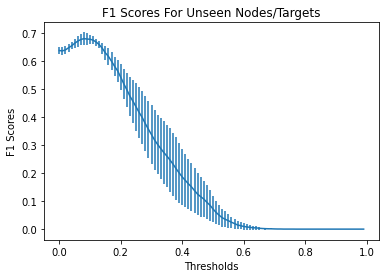

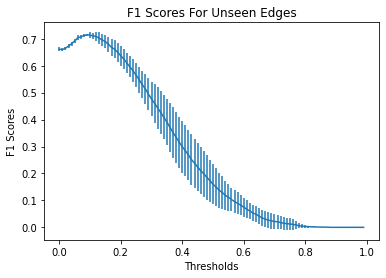

<Figure size 432x288 with 0 Axes>

In [31]:
vecnet_object.get_test_results(model_name = None, 
                            version_number = None, 
                            optimal_validation_model = None, 
                            drug_filter_list = drug_InChIKeys, 
                            target_filter_list = targets['target_aa_code'].tolist(), 
                            write_plot_to_disk = True, 
                            plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Drugs_NDM', 
                            plot_name = 'Test')

Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run0_07-13_19h11_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run1_07-13_19h14_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run2_07-13_19h17_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run3_07-13_19h20_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run4_07-13_19h23_epoch_19_idx_0.model


Unseen Nodes / Targets     Unseen Edges
AUC                  0.76 +/- 0.044  0.842 +/- 0.043
AUP                 0.903 +/- 0.034  0.962 +/- 0.015
F1 Score            0.888 +/- 0.024  0.918 +/- 0.009
F1 Threshold        0.038 +/- 0.034  0.046 +/- 0.016

Confusion Matrix - Unseen Nodes / Targets : 


Pred (0)       Pred (1)
True (0)  0.73 +/- 0.11  0.17 +/- 0.02
True (1)  0.27 +/- 0.11  0.83 +/- 0.02

Confusion Matrix - Unseen Edges : 


Pred (0)       Pred (1)
True (0)  0.64 +/- 0.06  0.12 +/- 0.02
True (1)  0.36 +/- 0.06  0.88 +/- 0.02

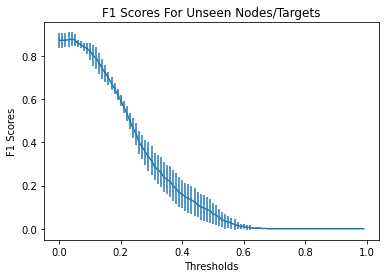

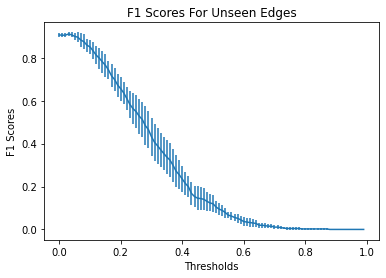

<Figure size 432x288 with 0 Axes>

In [32]:
vecnet_object.get_test_results(model_name = None, 
                            version_number = None, 
                            optimal_validation_model = None, 
                            drug_filter_list = NDM_InChIKeys, 
                            target_filter_list = targets['target_aa_code'].tolist(), 
                            write_plot_to_disk = True, 
                            plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Drugs_NDM', 
                            plot_name = 'Test')

#### Performance across degree bins

##### Proteins

In [210]:
q1 = np.quantile(degrees['degree'],0.25)
q2 = np.quantile(degrees['degree'],0.50)
q3 = np.quantile(degrees['degree'],0.75)

In [218]:
print('Different Quartiles: ', q1, q2, q3)

Different Quartiles:  1.0 2.0 4.0


In [219]:
bucket_names = ["0-Q1", "Q1-Q2", "Q2-Q3", "Q3-Max"]

degrees = pd.DataFrame(interactions['target_aa_code'].value_counts())
degrees['degree'] = degrees['target_aa_code']
degrees['target_aa_code'] = degrees.index
degrees = degrees.reset_index(drop = True)

bucket_1= degrees[(degrees['degree'] >= 0) & (degrees['degree'] < q1) ]['target_aa_code']
bucket_2= degrees[(degrees['degree'] >= q1) & (degrees['degree'] < q2) ]['target_aa_code']
bucket_3= degrees[(degrees['degree'] >= q2) & (degrees['degree'] < q3) ]['target_aa_code']
bucket_4= degrees[(degrees['degree'] >= q3) & (degrees['degree'] < max(degrees['degree'])) ]['target_aa_code']

Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run0_06-16_21h21_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run1_06-16_21h24_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run2_06-16_21h29_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run3_06-16_21h32_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run4_06-16_21h35_epoch_19_idx_0.model


Unseen Nodes / Targets     Unseen Edges
AUC                 0.603 +/- 0.035   0.61 +/- 0.017
AUP                 0.147 +/- 0.013   0.16 +/- 0.022
F1 Score            0.217 +/- 0.014  0.239 +/- 0.019
F1 Threshold        0.124 +/- 0.015  0.108 +/- 0.031

Confusion Matrix - Unseen Nodes / Targets : 


Pred (0)       Pred (1)
True (0)  0.92 +/- 0.01  0.85 +/- 0.02
True (1)  0.08 +/- 0.01  0.15 +/- 0.02

Confusion Matrix - Unseen Edges : 


Pred (0)       Pred (1)
True (0)  0.91 +/- 0.0  0.83 +/- 0.03
True (1)  0.09 +/- 0.0  0.17 +/- 0.03

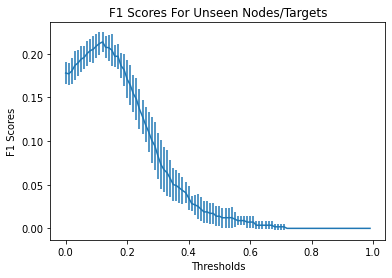

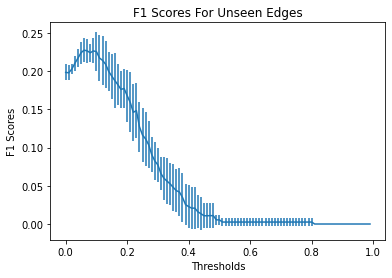

<Figure size 432x288 with 0 Axes>

In [224]:
vecnet_object.get_test_results(model_name = None, 
                            version_number = None, 
                            optimal_validation_model = None, 
                            drug_filter_list = [], 
                            target_filter_list = bucket_2.tolist(), 
                            write_plot_to_disk = True, 
                            plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Drugs_NDM', 
                            plot_name = 'Test')

Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run0_06-16_21h21_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run1_06-16_21h24_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run2_06-16_21h29_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run3_06-16_21h32_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run4_06-16_21h35_epoch_19_idx_0.model


/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1306: RuntimeWarning:

invalid value encountered in true_divide



Unseen Nodes / Targets     Unseen Edges
AUC                  0.62 +/- 0.048  0.612 +/- 0.035
AUP                 0.386 +/- 0.028  0.412 +/- 0.041
F1 Score            0.465 +/- 0.041  0.458 +/- 0.018
F1 Threshold        0.062 +/- 0.039   0.06 +/- 0.041

Confusion Matrix - Unseen Nodes / Targets : 


Pred (0)       Pred (1)
True (0)  0.83 +/- 0.02  0.64 +/- 0.07
True (1)  0.17 +/- 0.02  0.36 +/- 0.07

Confusion Matrix - Unseen Edges : 


Pred (0)       Pred (1)
True (0)  nan +/- nan  0.67 +/- 0.05
True (1)  nan +/- nan  0.33 +/- 0.05

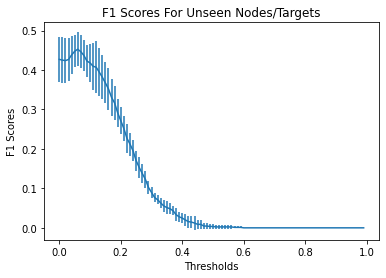

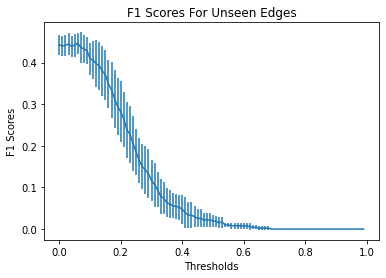

<Figure size 432x288 with 0 Axes>

In [225]:
vecnet_object.get_test_results(model_name = None, 
                            version_number = None, 
                            optimal_validation_model = None, 
                            drug_filter_list = [], 
                            target_filter_list = bucket_3.tolist(), 
                            write_plot_to_disk = True, 
                            plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Drugs_NDM', 
                            plot_name = 'Test')

In [124]:
vecnet_object.get_test_results(model_name = None, 
                            version_number = None, 
                            optimal_validation_model = None, 
                            drug_filter_list = [], 
                            target_filter_list = bucket_100_10000.tolist(), 
                            write_plot_to_disk = True, 
                            plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Drugs_NDM', 
                            plot_name = 'Test')

Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run0_06-16_21h21_epoch_19_idx_0.model


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

##### Ligands

In [136]:
bucket_names = ["0-10", "10-100", "100-1000"]

degrees = pd.DataFrame(interactions['InChiKey'].value_counts())
degrees['degree'] = degrees['InChiKey']
degrees['InChiKey'] = degrees.index
degrees = degrees.reset_index(drop = True)

bucket_0_10 = degrees[(degrees['degree'] >= 0) & (degrees['degree'] < 10) ]['InChiKey']
bucket_10_100 = degrees[(degrees['degree'] >= 10) & (degrees['degree'] < 100) ]['InChiKey']
bucket_100_10000 = degrees[(degrees['degree'] >= 100) & (degrees['degree'] < 10000) ]['InChiKey']

Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run0_06-16_21h21_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run1_06-16_21h24_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run2_06-16_21h29_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run3_06-16_21h32_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run4_06-16_21h35_epoch_19_idx_0.model


Unseen Nodes / Targets     Unseen Edges
AUC                 0.719 +/- 0.029  0.775 +/- 0.011
AUP                  0.571 +/- 0.05  0.705 +/- 0.025
F1 Score            0.575 +/- 0.015   0.628 +/- 0.02
F1 Threshold        0.106 +/- 0.012  0.124 +/- 0.027

Confusion Matrix - Unseen Nodes / Targets : 


Pred (0)      Pred (1)
True (0)  0.82 +/- 0.02  0.5 +/- 0.05
True (1)  0.18 +/- 0.02  0.5 +/- 0.05

Confusion Matrix - Unseen Edges : 


Pred (0)       Pred (1)
True (0)  0.81 +/- 0.01  0.41 +/- 0.05
True (1)  0.19 +/- 0.01  0.59 +/- 0.05

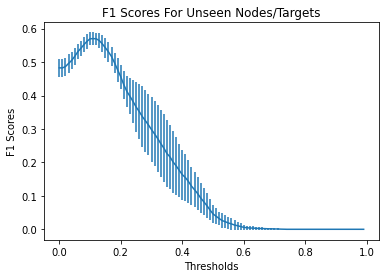

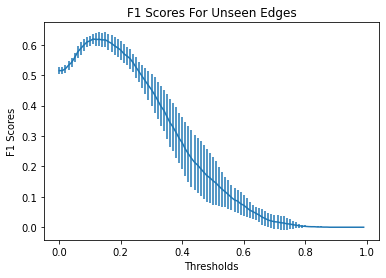

<Figure size 432x288 with 0 Axes>

In [140]:
vecnet_object.get_test_results(model_name = None, 
                            version_number = None, 
                            optimal_validation_model = None, 
                            drug_filter_list = bucket_0_10.tolist(), 
                            target_filter_list = [], 
                            write_plot_to_disk = True, 
                            plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Drugs_NDM', 
                            plot_name = 'Test')

Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run0_06-16_21h21_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run1_06-16_21h24_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run2_06-16_21h29_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run3_06-16_21h32_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run4_06-16_21h35_epoch_19_idx_0.model


/miniconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/miniconda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/miniconda/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/miniconda/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/miniconda/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars



Unseen Nodes / Targets     Unseen Edges
AUC                 0.667 +/- 0.068  0.862 +/- 0.022
AUP                  0.979 +/- 0.01  0.997 +/- 0.001
F1 Score            0.982 +/- 0.007  0.992 +/- 0.001
F1 Threshold            0.0 +/- 0.0      0.0 +/- 0.0

Confusion Matrix - Unseen Nodes / Targets : 


Pred (0) Pred (1)
True (0)        0        0
True (1)        0        0

Confusion Matrix - Unseen Edges : 


/miniconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/miniconda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/miniconda/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/miniconda/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/miniconda/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars



Pred (0) Pred (1)
True (0)        0        0
True (1)        0        0

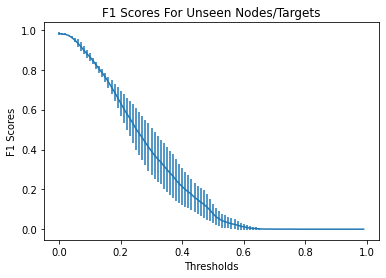

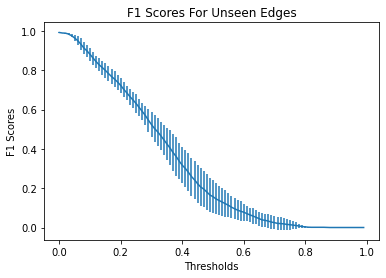

<Figure size 432x288 with 0 Axes>

In [141]:
vecnet_object.get_test_results(model_name = None, 
                            version_number = None, 
                            optimal_validation_model = None, 
                            drug_filter_list = bucket_10_100.tolist(), 
                            target_filter_list = [], 
                            write_plot_to_disk = True, 
                            plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Drugs_NDM', 
                            plot_name = 'Test')

In [142]:
vecnet_object.get_test_results(model_name = None, 
                            version_number = None, 
                            optimal_validation_model = None, 
                            drug_filter_list = bucket_100_10000.tolist(), 
                            target_filter_list = [], 
                            write_plot_to_disk = True, 
                            plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Drugs_NDM', 
                            plot_name = 'Test')

Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run0_06-16_21h21_epoch_19_idx_0.model


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

#### Performance across degree-ratio bins

##### Proteins

In [188]:
pos_interactions = vecnet_object.interactions[vecnet_object.interactions['Y'] == 1]
neg_interactions = vecnet_object.interactions[vecnet_object.interactions['Y'] == 0]

In [189]:
degrees = pd.DataFrame(pos_interactions['target_aa_code'].value_counts())
degrees['degree'] = degrees['target_aa_code']
degrees['target_aa_code'] = degrees.index
degrees = degrees.reset_index(drop = True)

In [190]:
neg_degrees = pd.DataFrame(neg_interactions['target_aa_code'].value_counts())
neg_degrees['degree_neg'] = neg_degrees['target_aa_code']
neg_degrees['target_aa_code'] = neg_degrees.index
neg_degrees = neg_degrees.reset_index(drop = True)

In [191]:
degrees_merged = degrees.merge(neg_degrees, on="target_aa_code", how = 'inner')

In [192]:
degrees_merged['degree_ratio'] = degrees_merged['degree'] / (degrees_merged['degree'] + degrees_merged['degree_neg'])

(array([1154.,  753.,  367.,  418.,  349.,  160.,  197.,  210.,  180.,
         182.]),
 array([0.03703704, 0.13298246, 0.22892788, 0.32487329, 0.42081871,
        0.51676413, 0.61270955, 0.70865497, 0.80460039, 0.90054581,
        0.99649123]),
 <a list of 10 Patch objects>)

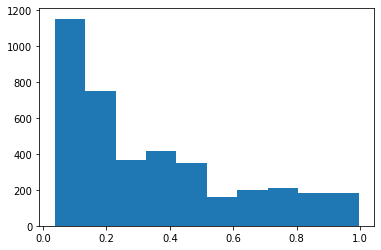

In [193]:
plt.hist(degrees_merged['degree_ratio'])

In [199]:
bucket_names = ["0-0.01", "0.01-0.1", "0.1-1"]

bucket_0_0p01 = degrees_merged[(degrees_merged['degree_ratio'] >= 0) & (degrees_merged['degree_ratio'] < 0.1) ]['target_aa_code']
#bucket_0p01_0p1 = degrees_merged[(degrees_merged['degree_ratio'] >= 0.01) & (degrees_merged['degree_ratio'] < 0.1) ]['target_aa_code']
bucket_0p1_1 = degrees_merged[(degrees_merged['degree_ratio'] >= 0.1) & (degrees_merged['degree_ratio'] < 0.5) ]['target_aa_code']

In [200]:
print('Proteins in bin 0-0.01: ', len(bucket_0_0p01))
#print('Proteins in bin 0.01-0.1: ', len(bucket_0p01_0p1))
print('Proteins in bin 0.1-1: ', len(bucket_0p1_1))

Proteins in bin 0-0.01:  710
Proteins in bin 0.1-1:  2102


Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run0_06-16_21h21_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run1_06-16_21h24_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run2_06-16_21h29_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run3_06-16_21h32_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run4_06-16_21h35_epoch_19_idx_0.model


Unseen Nodes / Targets     Unseen Edges
AUC                 0.742 +/- 0.029  0.792 +/- 0.009
AUP                 0.724 +/- 0.036  0.814 +/- 0.014
F1 Score            0.688 +/- 0.013  0.724 +/- 0.006
F1 Threshold        0.086 +/- 0.021  0.088 +/- 0.015

Confusion Matrix - Unseen Nodes / Targets : 


Pred (0)       Pred (1)
True (0)  0.76 +/- 0.03  0.38 +/- 0.06
True (1)  0.24 +/- 0.03  0.62 +/- 0.06

Confusion Matrix - Unseen Edges : 


Pred (0)       Pred (1)
True (0)  0.75 +/- 0.01  0.34 +/- 0.02
True (1)  0.25 +/- 0.01  0.66 +/- 0.02

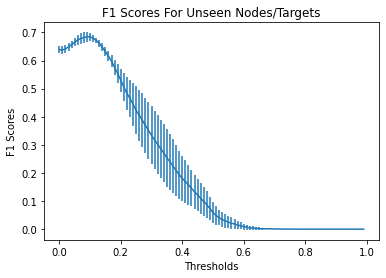

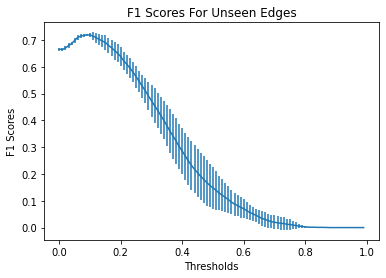

<Figure size 432x288 with 0 Axes>

In [164]:
vecnet_object.get_test_results(model_name = None, 
                            version_number = None, 
                            optimal_validation_model = None, 
                            drug_filter_list = [], 
                            target_filter_list = bucket_0_0p01.tolist(), 
                            write_plot_to_disk = True, 
                            plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Drugs_NDM', 
                            plot_name = 'Test')

In [186]:
len(bucket_0_0p01)

0

Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run0_06-16_21h21_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run1_06-16_21h24_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run2_06-16_21h29_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run3_06-16_21h32_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run4_06-16_21h35_epoch_19_idx_0.model


Unseen Nodes / Targets     Unseen Edges
AUC                 0.554 +/- 0.023  0.558 +/- 0.044
AUP                 0.108 +/- 0.024  0.117 +/- 0.019
F1 Score            0.183 +/- 0.041  0.196 +/- 0.019
F1 Threshold        0.088 +/- 0.032   0.12 +/- 0.089

Confusion Matrix - Unseen Nodes / Targets : 


Pred (0)       Pred (1)
True (0)  0.94 +/- 0.01  0.89 +/- 0.03
True (1)  0.06 +/- 0.01  0.11 +/- 0.03

Confusion Matrix - Unseen Edges : 


Pred (0)       Pred (1)
True (0)  0.95 +/- 0.03  0.86 +/- 0.06
True (1)  0.05 +/- 0.03  0.14 +/- 0.06

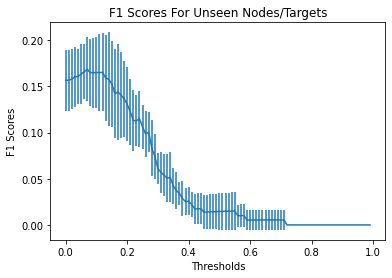

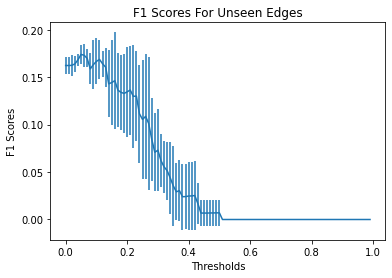

<Figure size 432x288 with 0 Axes>

In [165]:
vecnet_object.get_test_results(model_name = None, 
                            version_number = None, 
                            optimal_validation_model = None, 
                            drug_filter_list = [], 
                            target_filter_list = bucket_0p01_0p1.tolist(), 
                            write_plot_to_disk = True, 
                            plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Drugs_NDM', 
                            plot_name = 'Test')

Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run0_06-16_21h21_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run1_06-16_21h24_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run2_06-16_21h29_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run3_06-16_21h32_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run4_06-16_21h35_epoch_19_idx_0.model


Unseen Nodes / Targets     Unseen Edges
AUC                 0.714 +/- 0.058  0.782 +/- 0.014
AUP                 0.735 +/- 0.042  0.835 +/- 0.017
F1 Score             0.72 +/- 0.032  0.753 +/- 0.007
F1 Threshold        0.054 +/- 0.028   0.08 +/- 0.021

Confusion Matrix - Unseen Nodes / Targets : 


Pred (0)       Pred (1)
True (0)  0.72 +/- 0.03  0.36 +/- 0.06
True (1)  0.28 +/- 0.03  0.64 +/- 0.06

Confusion Matrix - Unseen Edges : 


Pred (0)       Pred (1)
True (0)  0.71 +/- 0.02  0.31 +/- 0.03
True (1)  0.29 +/- 0.02  0.69 +/- 0.03

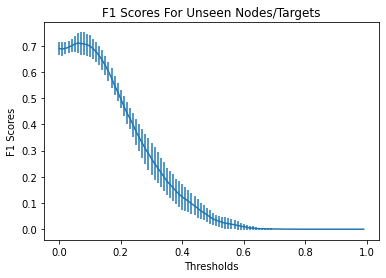

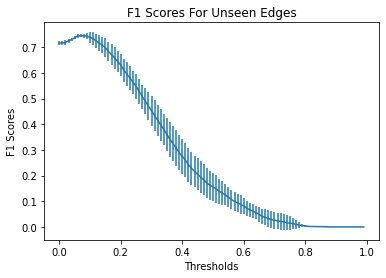

<Figure size 432x288 with 0 Axes>

In [166]:
vecnet_object.get_test_results(model_name = None, 
                            version_number = None, 
                            optimal_validation_model = None, 
                            drug_filter_list = [], 
                            target_filter_list = bucket_0p1_1.tolist(), 
                            write_plot_to_disk = True, 
                            plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Drugs_NDM', 
                            plot_name = 'Test')

##### Ligands

In [169]:
degrees = pd.DataFrame(pos_interactions['InChiKey'].value_counts())
degrees['degree'] = degrees['InChiKey']
degrees['InChiKey'] = degrees.index
degrees = degrees.reset_index(drop = True)

neg_degrees = pd.DataFrame(neg_interactions['InChiKey'].value_counts())
neg_degrees['degree_neg'] = neg_degrees['InChiKey']
neg_degrees['InChiKey'] = neg_degrees.index
neg_degrees = neg_degrees.reset_index(drop = True)

In [170]:
degrees_merged = degrees.merge(neg_degrees, on="InChiKey", how = 'inner')

degrees_merged['degree_ratio'] = degrees_merged['degree'] / (degrees_merged['degree'] + degrees_merged['degree_neg'])

(array([1170., 1550.,  706.,  884.,  714.,  250.,  348.,  388.,  284.,
         186.]),
 array([0.04761905, 0.14250253, 0.23738602, 0.3322695 , 0.42715299,
        0.52203647, 0.61691996, 0.71180344, 0.80668693, 0.90157042,
        0.9964539 ]),
 <a list of 10 Patch objects>)

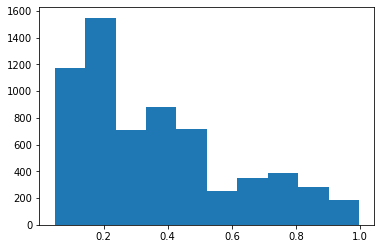

In [172]:
plt.hist(degrees_merged['degree_ratio'])

In [174]:
bucket_names = ["0-0.01", "0.01-0.1", "0.1-1"]

bucket_0_0p01 = degrees_merged[(degrees_merged['degree_ratio'] >= 0) & (degrees_merged['degree_ratio'] < 0.01) ]['InChiKey']
bucket_0p01_0p1 = degrees_merged[(degrees_merged['degree_ratio'] >= 0.01) & (degrees_merged['degree_ratio'] < 0.1) ]['InChiKey']
bucket_0p1_1 = degrees_merged[(degrees_merged['degree_ratio'] >= 0.1) & (degrees_merged['degree_ratio'] < 1) ]['InChiKey']

In [ ]:
print('Ligands in bin 0-0.01: ', len(bucket_0_0p01))
print('Ligands in bin 0.01-0.1: ', len(bucket_0p01_0p1))
print('Ligands in bin 0.1-1: ', len(bucket_0p1_1))

Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run0_06-16_21h21_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run1_06-16_21h24_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run2_06-16_21h29_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run3_06-16_21h32_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run4_06-16_21h35_epoch_19_idx_0.model


Unseen Nodes / Targets     Unseen Edges
AUC                 0.742 +/- 0.029  0.792 +/- 0.009
AUP                 0.724 +/- 0.037  0.814 +/- 0.014
F1 Score            0.688 +/- 0.013  0.724 +/- 0.006
F1 Threshold        0.086 +/- 0.021  0.088 +/- 0.015

Confusion Matrix - Unseen Nodes / Targets : 


Pred (0)       Pred (1)
True (0)  0.76 +/- 0.03  0.38 +/- 0.06
True (1)  0.24 +/- 0.03  0.62 +/- 0.06

Confusion Matrix - Unseen Edges : 


Pred (0)       Pred (1)
True (0)  0.75 +/- 0.01  0.34 +/- 0.02
True (1)  0.25 +/- 0.01  0.66 +/- 0.02

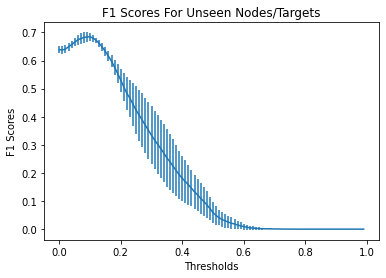

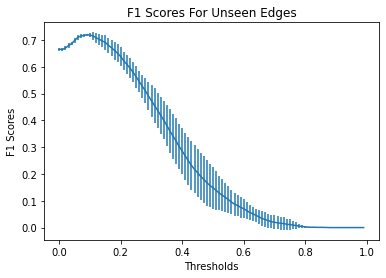

<Figure size 432x288 with 0 Axes>

In [176]:
vecnet_object.get_test_results(model_name = None, 
                            version_number = None, 
                            optimal_validation_model = None, 
                            drug_filter_list = bucket_0_0p01.tolist(), 
                            target_filter_list = [], 
                            write_plot_to_disk = True, 
                            plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Drugs_NDM', 
                            plot_name = 'Test')

Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run0_06-16_21h21_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run1_06-16_21h24_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run2_06-16_21h29_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run3_06-16_21h32_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run4_06-16_21h35_epoch_19_idx_0.model


Unseen Nodes / Targets     Unseen Edges
AUC                  0.657 +/- 0.06  0.664 +/- 0.036
AUP                 0.296 +/- 0.067    0.35 +/- 0.07
F1 Score            0.362 +/- 0.066  0.387 +/- 0.055
F1 Threshold         0.112 +/- 0.04    0.11 +/- 0.03

Confusion Matrix - Unseen Nodes / Targets : 


Pred (0)       Pred (1)
True (0)  0.91 +/- 0.01  0.71 +/- 0.09
True (1)  0.09 +/- 0.01  0.29 +/- 0.09

Confusion Matrix - Unseen Edges : 


Pred (0)      Pred (1)
True (0)  0.92 +/- 0.03  0.7 +/- 0.05
True (1)  0.08 +/- 0.03  0.3 +/- 0.05

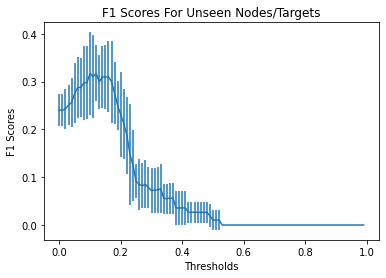

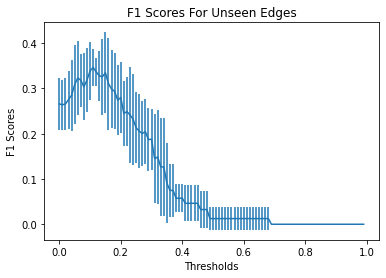

<Figure size 432x288 with 0 Axes>

In [177]:
vecnet_object.get_test_results(model_name = None, 
                            version_number = None, 
                            optimal_validation_model = None, 
                            drug_filter_list = bucket_0p01_0p1.tolist(), 
                            target_filter_list = [], 
                            write_plot_to_disk = True, 
                            plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Drugs_NDM', 
                            plot_name = 'Test')

Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run0_06-16_21h21_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run1_06-16_21h24_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run2_06-16_21h29_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run3_06-16_21h32_epoch_19_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_nodes_v00_run4_06-16_21h35_epoch_19_idx_0.model


Unseen Nodes / Targets     Unseen Edges
AUC                  0.76 +/- 0.026  0.811 +/- 0.009
AUP                  0.76 +/- 0.034  0.841 +/- 0.015
F1 Score            0.718 +/- 0.019  0.751 +/- 0.011
F1 Threshold        0.084 +/- 0.021   0.09 +/- 0.017

Confusion Matrix - Unseen Nodes / Targets : 


Pred (0)       Pred (1)
True (0)  0.75 +/- 0.04  0.34 +/- 0.06
True (1)  0.25 +/- 0.04  0.66 +/- 0.06

Confusion Matrix - Unseen Edges : 


Pred (0)       Pred (1)
True (0)  0.75 +/- 0.01  0.29 +/- 0.03
True (1)  0.25 +/- 0.01  0.71 +/- 0.03

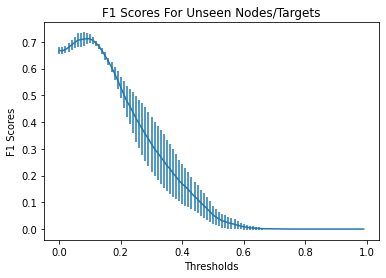

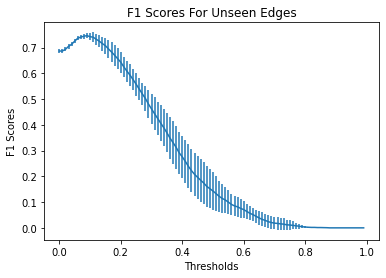

<Figure size 432x288 with 0 Axes>

In [178]:
vecnet_object.get_test_results(model_name = None, 
                            version_number = None, 
                            optimal_validation_model = None, 
                            drug_filter_list = bucket_0p1_1.tolist(), 
                            target_filter_list = [], 
                            write_plot_to_disk = True, 
                            plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes_Drugs_NDM', 
                            plot_name = 'Test')

#### Saving the VecNet object

In [30]:
pkl.dump(vecnet_object, file = open("/data/sars-busters-consolidated/GitData/VecNet_unseen_nodes.pickle", "wb"))

In [183]:
vecnet_object.train_sets[0].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/train_0.csv')
vecnet_object.train_sets[1].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/train_1.csv')
vecnet_object.train_sets[2].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/train_2.csv')
vecnet_object.train_sets[3].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/train_3.csv')
vecnet_object.train_sets[4].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/train_4.csv')

vecnet_object.nodes_test[0].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/test_unseen_nodes_0.csv')
vecnet_object.nodes_test[1].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/test_unseen_nodes_1.csv')
vecnet_object.nodes_test[2].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/test_unseen_nodes_2.csv')
vecnet_object.nodes_test[3].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/test_unseen_nodes_3.csv')
vecnet_object.nodes_test[4].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/test_unseen_nodes_4.csv')

vecnet_object.edges_test[0].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/test_unseen_edges_0.csv')
vecnet_object.edges_test[1].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/test_unseen_edges_1.csv')
vecnet_object.edges_test[2].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/test_unseen_edges_2.csv')
vecnet_object.edges_test[3].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/test_unseen_edges_3.csv')
vecnet_object.edges_test[4].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/test_unseen_edges_4.csv')

In [184]:
vecnet_object.nodes_validation[0].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/validation_unseen_nodes_0.csv')
vecnet_object.nodes_validation[1].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/validation_unseen_nodes_1.csv')
vecnet_object.nodes_validation[2].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/validation_unseen_nodes_2.csv')
vecnet_object.nodes_validation[3].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/validation_unseen_nodes_3.csv')
vecnet_object.nodes_validation[4].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/validation_unseen_nodes_4.csv')

vecnet_object.edges_validation[0].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/validation_unseen_edges_0.csv')
vecnet_object.edges_validation[1].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/validation_unseen_edges_1.csv')
vecnet_object.edges_validation[2].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/validation_unseen_edges_2.csv')
vecnet_object.edges_validation[3].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/validation_unseen_edges_3.csv')
vecnet_object.edges_validation[4].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/validation_unseen_edges_4.csv')

#### Predictions for SARS-CoV-2 genes


In [33]:
sars_targets = pd.read_csv('/data/External Predictions/SARS Sequences/20201203_Targets_Sequences_SARS_Cov2.csv')

In [36]:
unique_ligands = set(test_creation_interactions['InChiKey'].tolist())

InChiKey_list = []
target_aa_code_list = []
ID_list = []
gene_list = []

for lig in tqdm(unique_ligands):
    for index, row in sars_targets.iterrows():
        InChiKey_list.append(lig)
        target_aa_code_list.append(row['Sequence'])
        ID_list.append(row['ID'])
        gene_list.append(row['gene'])
        
sars_preidcitons = pd.DataFrame()

sars_preidcitons['InChiKey'] = InChiKey_list
sars_preidcitons['target_aa_code'] = target_aa_code_list
sars_preidcitons['ID'] = ID_list
sars_preidcitons['gene'] = gene_list

  0%|          | 0/8111 [00:00<?, ?it/s]

In [37]:
vecnet_object.mol2vec_location = '/data/sars-busters/Mol2Vec/model_300dim.pkl',
vecnet_object.protvec_location = '/home/sars-busters/Mol2Vec/Results/protVec_100d_3grams.csv',

vecnet_object.protvec_model = pd.read_csv('/home/sars-busters/Mol2Vec/Results/protVec_100d_3grams.csv', delimiter = '\t')
vecnet_object.mol2vec_model = word2vec.Word2Vec.load('/data/sars-busters/Mol2Vec/model_300dim.pkl')

In [38]:
sars_preidcitons_5fold_average = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = [sars_preidcitons],
                                                                                     get_drug_embed = False,
                                                                                     get_target_embed = True,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = [],
                                                                                     return_dataframes = True )


Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_0/vecnet_ds2_5_fold_unseen_nodes_v00_run0_07-13_19h11_epoch_19_idx_0.model
filtered_nodes_test :  (267663, 4)
Drugs :  8111
Targets :  33


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (267663, 100) (267663, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_1/vecnet_ds2_5_fold_unseen_nodes_v00_run1_07-13_19h14_epoch_19_idx_0.model
filtered_nodes_test :  (267663, 4)
Drugs :  8111
Targets :  33


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (267663, 100) (267663, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_2/vecnet_ds2_5_fold_unseen_nodes_v00_run2_07-13_19h17_epoch_19_idx_0.model
filtered_nodes_test :  (267663, 4)
Drugs :  8111
Targets :  33


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (267663, 100) (267663, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_3/vecnet_ds2_5_fold_unseen_nodes_v00_run3_07-13_19h20_epoch_19_idx_0.model
filtered_nodes_test :  (267663, 4)
Drugs :  8111
Targets :  33


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (267663, 100) (267663, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_4/vecnet_ds2_5_fold_unseen_nodes_v00_run4_07-13_19h23_epoch_19_idx_0.model
filtered_nodes_test :  (267663, 4)
Drugs :  8111
Targets :  33


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (267663, 100) (267663, 300)
unseen_targets_pred :  (267663,)
list :  267663


In [39]:
print('Expected number of ligands: ',len(set(sars_preidcitons['InChiKey'].tolist())))
print('Ligands present in prediction: ',len(set(sars_preidcitons_5fold_average[0]['InChiKey'].tolist())))

Expected number of ligands:  8111
Ligands present in prediction:  8111


In [40]:
print('Expected number of pairs: ',len(sars_preidcitons))
print('Pairs present in prediction: ',len(sars_preidcitons_5fold_average[0]))

Expected number of pairs:  267663
Pairs present in prediction:  267663


Text(0.5, 1.0, 'VecNet Predictions for SARS-CoV-2 genes')

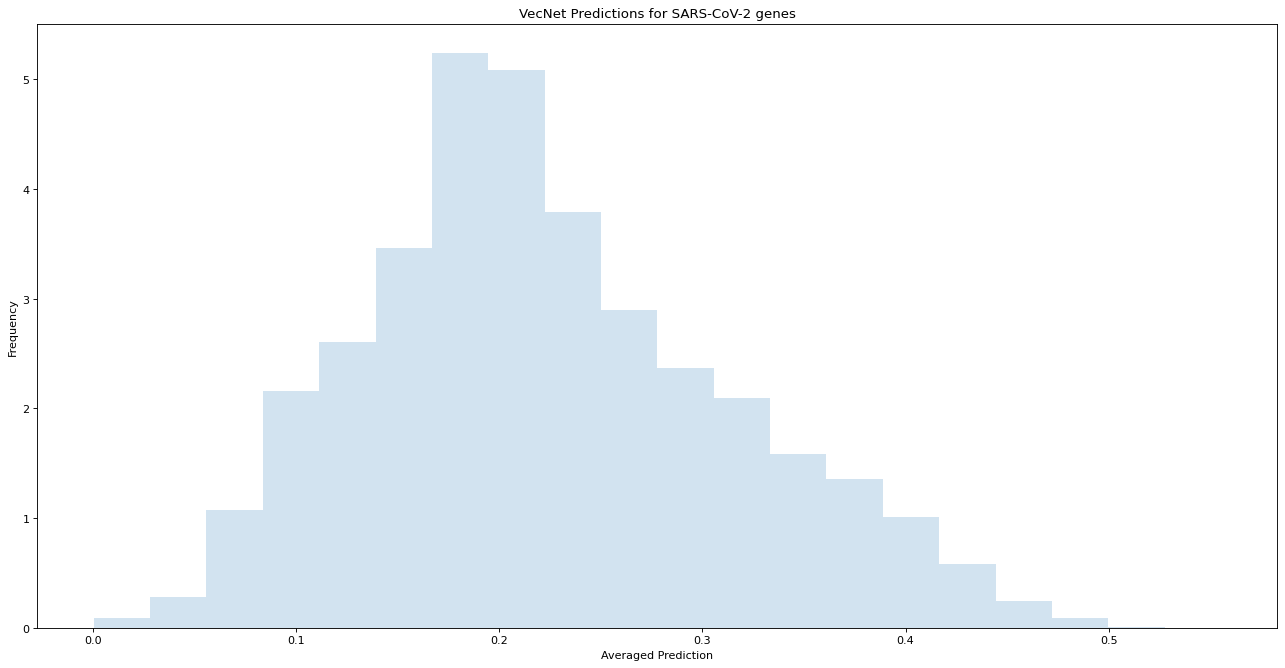

In [41]:
figure(figsize=(20, 10), dpi=80)
plt.hist(sars_preidcitons_5fold_average[0]['Averaged Predictions'].tolist(),density=True,alpha=0.2,bins=20)
plt.xlabel('Averaged Prediction')
plt.ylabel('Frequency')
plt.title('VecNet Predictions for SARS-CoV-2 genes')

In [42]:
sars_preidcitons_5fold_average[0].to_csv('/data/sars-busters-consolidated/GitData/sars_predicitons_unseen_nodes.csv')

#### Predictions for Human Genes

In [43]:
human_targets = pd.read_csv('../../covid-target-finder/data/intermediate/330_corona_genes_preprocessed.csv')

In [44]:
human_targets = human_targets[['hgnc_symbol','amino_acid_sequence']]

In [45]:
processed_amino_acid_sequence = []

for index, row in tqdm(human_targets.iterrows()):
    if '*' in row['amino_acid_sequence']:
        aa_seq_chinks = row['amino_acid_sequence'].split('*')
        processed_amino_acid_sequence.append(max(aa_seq_chinks, key=len))
    else:
        processed_amino_acid_sequence.append(row['amino_acid_sequence'])
        
human_targets['target_aa_code'] = processed_amino_acid_sequence

0it [00:00, ?it/s]

In [46]:
unique_ligands = set(test_creation_interactions['InChiKey'].tolist())

InChiKey_list = []
target_aa_code_list = []
ID_list = []
gene_list = []

for lig in tqdm(unique_ligands):
    for index, row in human_targets.iterrows():
        InChiKey_list.append(lig)
        target_aa_code_list.append(row['target_aa_code'])
        ID_list.append(row['hgnc_symbol'])
        
human_predicitons = pd.DataFrame()

human_predicitons['InChiKey'] = InChiKey_list
human_predicitons['target_aa_code'] = target_aa_code_list
human_predicitons['hgnc_symbol'] = ID_list

  0%|          | 0/8111 [00:00<?, ?it/s]

In [47]:
human_preidcitons_5fold_average = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = [human_predicitons],
                                                                                     get_drug_embed = False,
                                                                                     get_target_embed = True,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = [],
                                                                                     return_dataframes = True )

Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_0/vecnet_ds2_5_fold_unseen_nodes_v00_run0_07-13_19h11_epoch_19_idx_0.model
filtered_nodes_test :  (2676630, 3)
Drugs :  8111
Targets :  330


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (2676630, 100) (2676630, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_1/vecnet_ds2_5_fold_unseen_nodes_v00_run1_07-13_19h14_epoch_19_idx_0.model
filtered_nodes_test :  (2676630, 3)
Drugs :  8111
Targets :  330


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (2676630, 100) (2676630, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_2/vecnet_ds2_5_fold_unseen_nodes_v00_run2_07-13_19h17_epoch_19_idx_0.model
filtered_nodes_test :  (2676630, 3)
Drugs :  8111
Targets :  330


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (2676630, 100) (2676630, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_3/vecnet_ds2_5_fold_unseen_nodes_v00_run3_07-13_19h20_epoch_19_idx_0.model
filtered_nodes_test :  (2676630, 3)
Drugs :  8111
Targets :  330


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (2676630, 100) (2676630, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_4/vecnet_ds2_5_fold_unseen_nodes_v00_run4_07-13_19h23_epoch_19_idx_0.model
filtered_nodes_test :  (2676630, 3)
Drugs :  8111
Targets :  330


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (2676630, 100) (2676630, 300)
unseen_targets_pred :  (2676630,)
list :  2676630


In [48]:
print('Expected number of ligands: ',len(set(human_predicitons['InChiKey'].tolist())))
print('Ligands present in prediction: ',len(set(human_preidcitons_5fold_average[0]['InChiKey'].tolist())))

print('Expected number of pairs: ',len(human_predicitons))
print('Pairs present in prediction: ',len(human_preidcitons_5fold_average[0]))

Expected number of ligands:  8111
Ligands present in prediction:  8111
Expected number of pairs:  2676630
Pairs present in prediction:  2676630


Text(0.5, 1.0, 'VecNet Predictions for human genes')

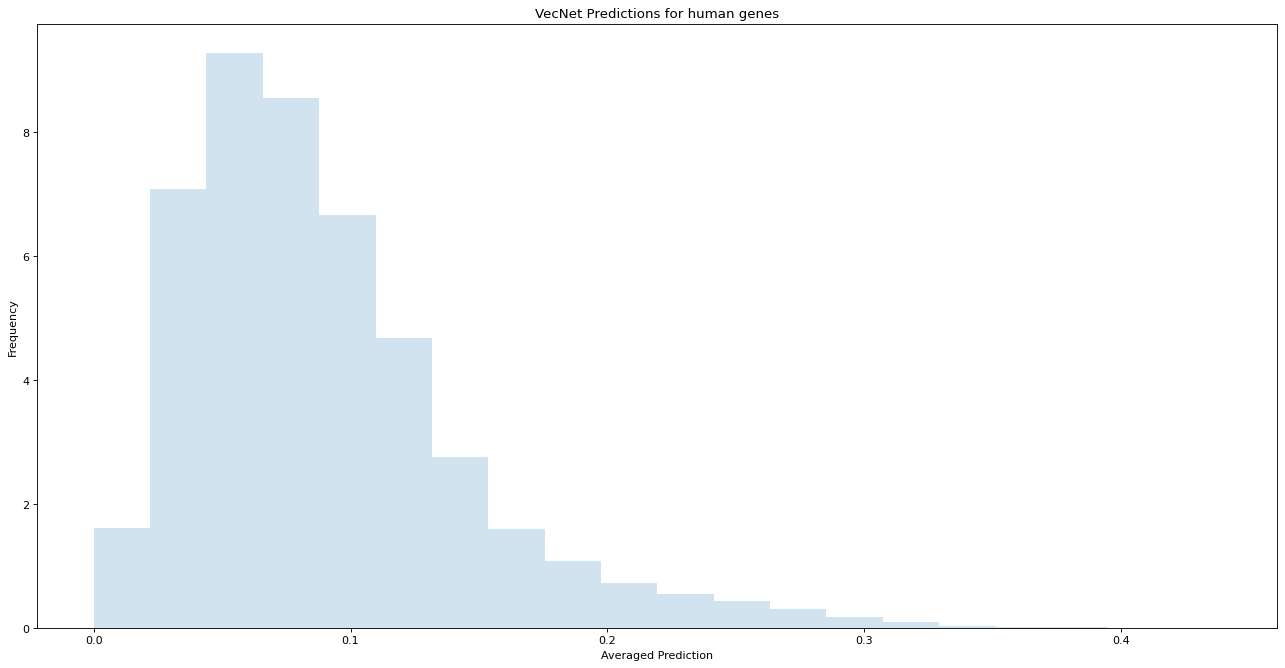

In [49]:
figure(figsize=(20, 10), dpi=80)
plt.hist(human_preidcitons_5fold_average[0]['Averaged Predictions'].tolist(),density=True,alpha=0.2,bins=20)
plt.xlabel('Averaged Prediction')
plt.ylabel('Frequency')
plt.title('VecNet Predictions for human genes')

In [50]:
human_preidcitons_5fold_average[0].to_csv('/data/sars-busters-consolidated/GitData/human_predicitons_unseen_nodes.csv')

#### Example Prediction for Unseen Nodes 

In [51]:
## Unseen ligand - Benzaldehyde

'HUMNYLRZRPPJDN-UHFFFAOYSA-N' in unique_ligands

False

In [52]:
unseen_nodes_example = pd.DataFrame()

unseen_nodes_example['InChiKey'] = ['HUMNYLRZRPPJDN-UHFFFAOYSA-N']
unseen_nodes_example['SMILE'] = ['C1=CC=C(C=C1)C=O']
unseen_nodes_example['target_aa_code'] = sars_targets['Sequence'].tolist()[0]

In [53]:
unseen_nodes_example

InChiKey             SMILE  \
0  HUMNYLRZRPPJDN-UHFFFAOYSA-N  C1=CC=C(C=C1)C=O   

                                      target_aa_code  
0  MPAAAGDGLLGEPAAPGGGGGAEDAARPAAACEGSFLPAWVSGVPR...

In [54]:
unseen_nodes_example_5fold_average = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = [unseen_nodes_example],
                                                                                     get_drug_embed = True,
                                                                                     get_target_embed = True,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = [],
                                                                                     return_dataframes = True )


Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_0/vecnet_ds2_5_fold_unseen_nodes_v00_run0_07-13_19h11_epoch_19_idx_0.model
filtered_nodes_test :  (1, 3)
Drugs :  1
Targets :  1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (1, 100) (1, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_1/vecnet_ds2_5_fold_unseen_nodes_v00_run1_07-13_19h14_epoch_19_idx_0.model
filtered_nodes_test :  (1, 3)
Drugs :  1
Targets :  1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (1, 100) (1, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_2/vecnet_ds2_5_fold_unseen_nodes_v00_run2_07-13_19h17_epoch_19_idx_0.model
filtered_nodes_test :  (1, 3)
Drugs :  1
Targets :  1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (1, 100) (1, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_3/vecnet_ds2_5_fold_unseen_nodes_v00_run3_07-13_19h20_epoch_19_idx_0.model
filtered_nodes_test :  (1, 3)
Drugs :  1
Targets :  1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (1, 100) (1, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_4/vecnet_ds2_5_fold_unseen_nodes_v00_run4_07-13_19h23_epoch_19_idx_0.model
filtered_nodes_test :  (1, 3)
Drugs :  1
Targets :  1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (1, 100) (1, 300)
unseen_targets_pred :  (1,)
list :  1


In [55]:
unseen_nodes_example_5fold_average[0]

InChiKey             SMILE  \
0  HUMNYLRZRPPJDN-UHFFFAOYSA-N  C1=CC=C(C=C1)C=O   

                                      target_aa_code  Averaged Predictions  
0  MPAAAGDGLLGEPAAPGGGGGAEDAARPAAACEGSFLPAWVSGVPR...              0.284132

#### Predicting on CHEMBL data

In [56]:
chembl = pd.read_csv('chembl24_active_&_inactive_interactions_w_seq.csv')

In [57]:
chembl = chembl.rename(columns={'target_chemblid':'InChiKey','usmiles':'SMILE','Sequence':'target_aa_code'})

In [58]:
chembl = chembl[~chembl['target_aa_code'].isna()]

In [59]:
chembl_5fold_average = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                            version_number = None,
                                                                            model_paths = [],
                                                                            optimal_validation_model = None,
                                                                            test_sets = [chembl],
                                                                            get_drug_embed = True,
                                                                            get_target_embed = True,
                                                                            drug_filter_list = [],
                                                                            target_filter_list = [],
                                                                            return_dataframes = True )


Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_0/vecnet_ds2_5_fold_unseen_nodes_v00_run0_07-13_19h11_epoch_19_idx_0.model
filtered_nodes_test :  (9092, 11)
Drugs :  352
Targets :  346


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (9092, 100) (9092, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_1/vecnet_ds2_5_fold_unseen_nodes_v00_run1_07-13_19h14_epoch_19_idx_0.model
filtered_nodes_test :  (9092, 11)
Drugs :  352
Targets :  346


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (9092, 100) (9092, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_2/vecnet_ds2_5_fold_unseen_nodes_v00_run2_07-13_19h17_epoch_19_idx_0.model
filtered_nodes_test :  (9092, 11)
Drugs :  352
Targets :  346


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (9092, 100) (9092, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_3/vecnet_ds2_5_fold_unseen_nodes_v00_run3_07-13_19h20_epoch_19_idx_0.model
filtered_nodes_test :  (9092, 11)
Drugs :  352
Targets :  346


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (9092, 100) (9092, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-101/Run_4/vecnet_ds2_5_fold_unseen_nodes_v00_run4_07-13_19h23_epoch_19_idx_0.model
filtered_nodes_test :  (9092, 11)
Drugs :  352
Targets :  346


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (9092, 100) (9092, 300)
unseen_targets_pred :  (9092,)
list :  9092


In [60]:
true_labels = []

for index, row in chembl_5fold_average[0].iterrows():
    if row['activity_class'] == 'active':
        true_labels.append(1)
    else:
        true_labels.append(0)

In [61]:
chembl_5fold_average[0]['activity_class'].value_counts()

active      5049
inactive    4043
Name: activity_class, dtype: int64

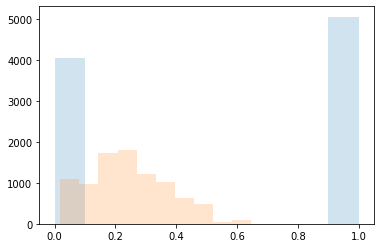

In [62]:
plt.hist(true_labels,alpha=0.2)
plt.hist(chembl_5fold_average[0]['Averaged Predictions'],alpha=0.2)
plt.show()

In [63]:
roc_auc_score(true_labels,chembl_5fold_average[0]['Averaged Predictions'].tolist())

0.4782349889215787

In [64]:
average_precision_score(true_labels,chembl_5fold_average[0]['Averaged Predictions'].tolist())

0.5425611071793744

In [65]:
confusion_matrix(true_labels,[1 if x > 0.086 else 0 for x in chembl_5fold_average[0]['Averaged Predictions'].tolist()])

array([[ 376, 3667],
       [ 722, 4327]])

In [66]:
chembl_5fold_average[0]['Y'] = true_labels
chembl_5fold_average[0]['binary_Y'] = [1 if x > 0.094 else 0 for x in chembl_5fold_average[0]['Averaged Predictions'].tolist()]

In [67]:
chembl_fp = chembl_5fold_average[0][(chembl_5fold_average[0].Y == 0) & (chembl_5fold_average[0].binary_Y == 1)]

In [68]:
chembl_tp = chembl_5fold_average[0][(chembl_5fold_average[0].Y == 1) & (chembl_5fold_average[0].binary_Y == 1)]

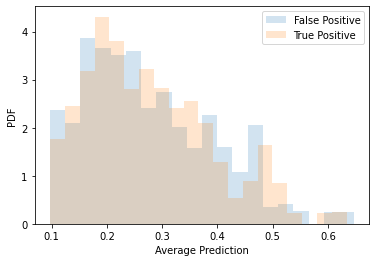

In [69]:
plt.hist(chembl_fp['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='False Positive')
plt.hist(chembl_tp['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='True Positive')
plt.legend()
plt.xlabel('Average Prediction')
plt.ylabel('PDF')
plt.show()

In [70]:
chembl_fn = chembl_5fold_average[0][(chembl_5fold_average[0].Y == 1) & (chembl_5fold_average[0].binary_Y == 0)]

In [71]:
chembl_tn = chembl_5fold_average[0][(chembl_5fold_average[0].Y == 0) & (chembl_5fold_average[0].binary_Y == 0)]

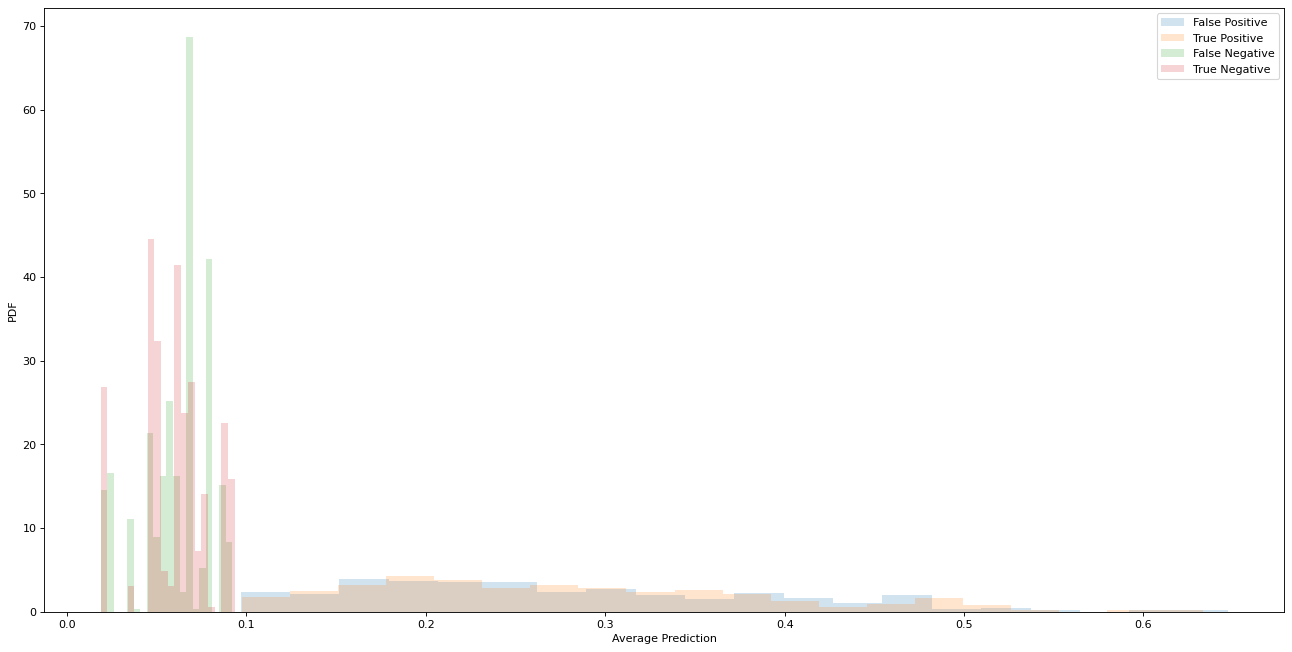

In [72]:
figure(figsize=(20, 10), dpi=80)
plt.hist(chembl_fp['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='False Positive')
plt.hist(chembl_tp['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='True Positive')
plt.hist(chembl_fn['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='False Negative')
plt.hist(chembl_tn['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='True Negative')
plt.legend()
plt.xlabel('Average Prediction')
plt.ylabel('PDF')
plt.show()

In [73]:
from sklearn.metrics import matthews_corrcoef

for th in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    print(matthews_corrcoef(true_labels,[1 if x > th else 0 for x in chembl_5fold_average[0]['Averaged Predictions'].tolist()]))

-0.05490204633138332
-0.03225918179306522
0.00707933280047033
-0.047762834095521615
-0.003369924003278151
-0.006688836939921604
0.0
0.0
0.0


/miniconda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning:

invalid value encountered in double_scalars



In [74]:
chembl_all = pd.concat([chembl_fp,chembl_fn,chembl_tp,chembl_tn])

Text(0, 0.5, 'PDF')

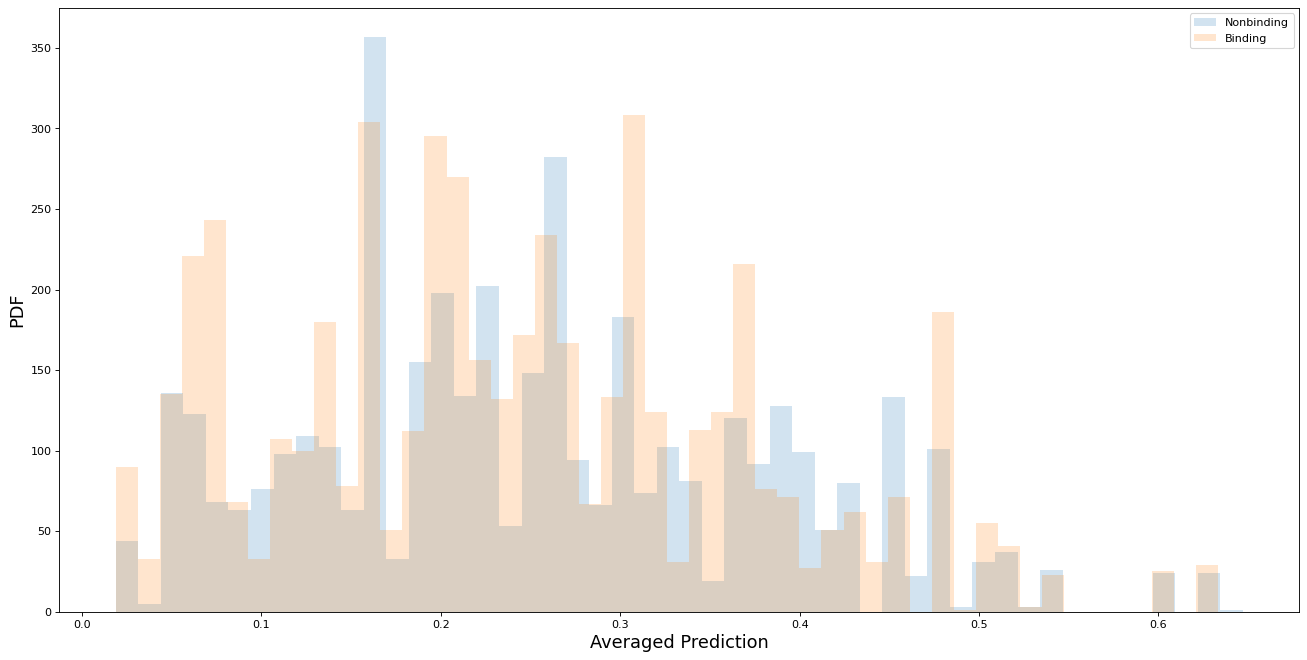

In [75]:
figure(figsize=(20, 10), dpi=80)
plt.hist(chembl_all[chembl_all['Y']==0]['Averaged Predictions'],density=False,alpha=0.2,bins=50,label='Nonbinding')
plt.hist(chembl_all[chembl_all['Y']==1]['Averaged Predictions'],density=False,alpha=0.2,bins=50,label='Binding')
plt.legend()
plt.xlabel('Averaged Prediction',fontsize=16)
plt.ylabel('PDF',fontsize=16)

In [76]:
chembl_all

InChiKey                                          pref_name  \
42    CHEMBL1075104  Leucine-rich repeat serine/threonine-protein k...   
43    CHEMBL1075104  Leucine-rich repeat serine/threonine-protein k...   
47    CHEMBL1075319  Transient receptor potential cation channel su...   
48    CHEMBL1075319  Transient receptor potential cation channel su...   
49    CHEMBL1075319  Transient receptor potential cation channel su...   
...             ...                                                ...   
8774     CHEMBL5658                           Prostaglandin E synthase   
8775     CHEMBL5658                           Prostaglandin E synthase   
8776     CHEMBL5658                           Prostaglandin E synthase   
8814     CHEMBL5658                           Prostaglandin E synthase   
8815     CHEMBL5658                           Prostaglandin E synthase   

         target_type                                              SMILE  \
42    SINGLE PROTEIN  CC1(C)C(=O)N(C2CCc3c(O)cccc32)c2nc(Nc3ccccc3)n...   
43    SINGLE PROTEIN        NC(=O)c1ncc(NC2CCCCC2N)nc1-c1nc2ccccc2[nH]1   
47    SINGLE PROTEIN  CC(c1cccc(Cl)c1)N(C(=O)c1ccccc1)C(C(N)=O)c1ccccc1   
48    SINGLE PROTEIN  CC(c1cccc(Cl)c1)N(C(=O)c1ccccc1)C(C(N)=O)c1cccnc1   
49    SINGLE PROTEIN  CC(c1cccc(Cl)c1)N(C(=O)c1ccccc1N)C(C(N)=O)c1cc...   
...              ...                                                ...   
8774  SINGLE PROTEIN                   COc1cc(-c2cc3ccccc3c(=O)o2)ccc1O   
8775  SINGLE PROTEIN                COc1ccc(-c2cc3cccc(O)c3c(=O)o2)cc1O   
8776  SINGLE PROTEIN                   COc1ccc(-c2cc3ccccc3c(=O)o2)cc1O   
8814  SINGLE PROTEIN                  O=c1oc(-c2ccc(O)cc2)cc2cccc(O)c12   
8815  SINGLE PROTEIN                        O=c1oc(-c2ccccc2)cc2ccccc12   

      pchembl_median  doc_id  year  activity_threshold activity_class  \
42              6.78  102068  2017                 7.5       inactive   
43              6.89  101534  2016                 7.5       inactive   
47              6.40  101997  2017                 6.5       inactive   
48              5.39  101997  2017                 6.5       inactive   
49              6.38  101997  2017                 6.5       inactive   
...              ...     ...   ...                 ...            ...   
8774            5.20  101955  2016                 6.0       inactive   
8775            4.95  101955  2016                 6.0       inactive   
8776            5.01  101955  2016                 6.0       inactive   
8814            5.15  101955  2016                 6.0       inactive   
8815            5.02  101955  2016                 6.0       inactive   

     UniprotID                                     target_aa_code  \
42      Q5S007  MASGSCQGCEEDEETLKKLIVRLNNVQEGKQIETLVQILEDLLVFT...   
43      Q5S007  MASGSCQGCEEDEETLKKLIVRLNNVQEGKQIETLVQILEDLLVFT...   
47      Q7Z2W7  MSFRAARLSMRNRRNDTLDSTRTLYSSASRSTDLSYSESDLVNFIQ...   
48      Q7Z2W7  MSFRAARLSMRNRRNDTLDSTRTLYSSASRSTDLSYSESDLVNFIQ...   
49      Q7Z2W7  MSFRAARLSMRNRRNDTLDSTRTLYSSASRSTDLSYSESDLVNFIQ...   
...        ...                                                ...   
8774    O14684  MPAHSLVMSSPALPAFLLCSTLLVIKMYVVAIITGQVRLRKKAFAN...   
8775    O14684  MPAHSLVMSSPALPAFLLCSTLLVIKMYVVAIITGQVRLRKKAFAN...   
8776    O14684  MPAHSLVMSSPALPAFLLCSTLLVIKMYVVAIITGQVRLRKKAFAN...   
8814    O14684  MPAHSLVMSSPALPAFLLCSTLLVIKMYVVAIITGQVRLRKKAFAN...   
8815    O14684  MPAHSLVMSSPALPAFLLCSTLLVIKMYVVAIITGQVRLRKKAFAN...   

      Averaged Predictions  Y  binary_Y  
42                0.336337  0         1  
43                0.336337  0         1  
47                0.209629  0         1  
48                0.209629  0         1  
49                0.209629  0         1  
...                    ... ..       ...  
8774              0.052266  0         0  
8775              0.052266  0         0  
8776              0.052266  0         0  
8814              0.052266  0         0  
8815              0.052266  0         0  

[9092 rows

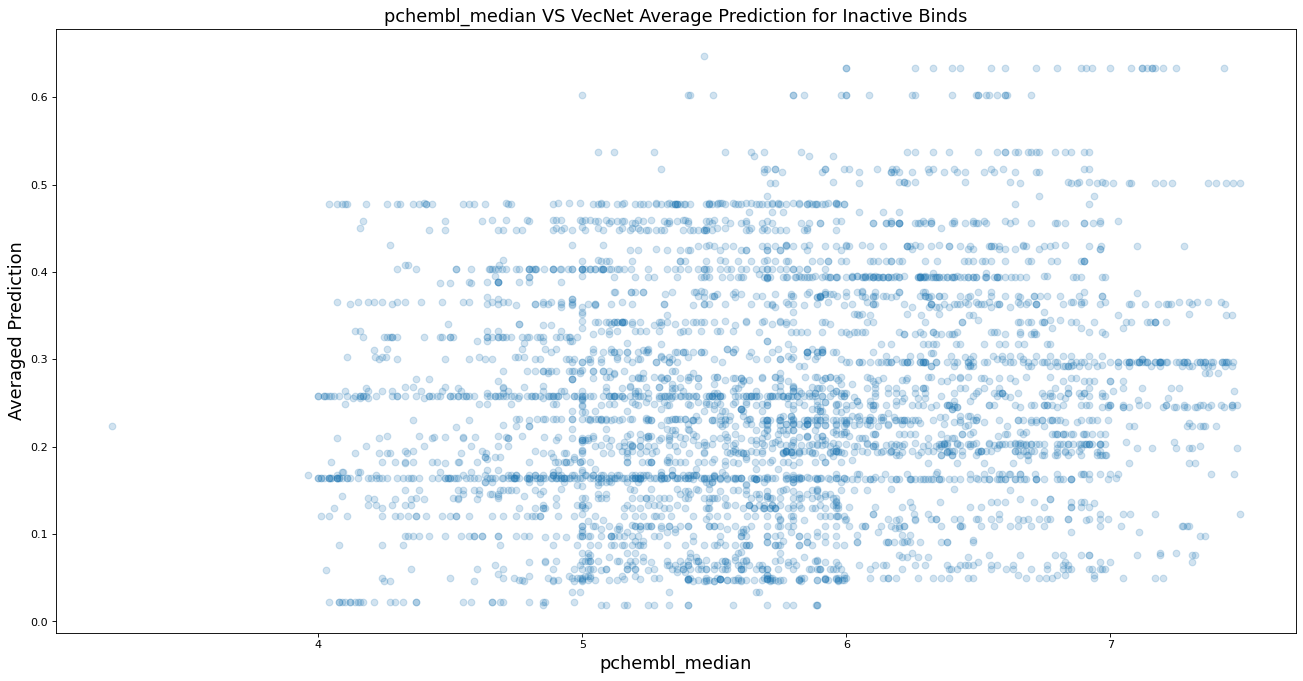

In [77]:
figure(figsize=(20, 10), dpi=80)
plt.title('pchembl_median VS VecNet Average Prediction for Inactive Binds',fontsize=16)
plt.scatter(chembl_all[chembl_all['Y']==0]['pchembl_median'],chembl_all[chembl_all['Y']==0]['Averaged Predictions'],alpha=0.2)
plt.xlabel('pchembl_median',fontsize=16)
plt.ylabel('Averaged Prediction',fontsize=16)
plt.show()

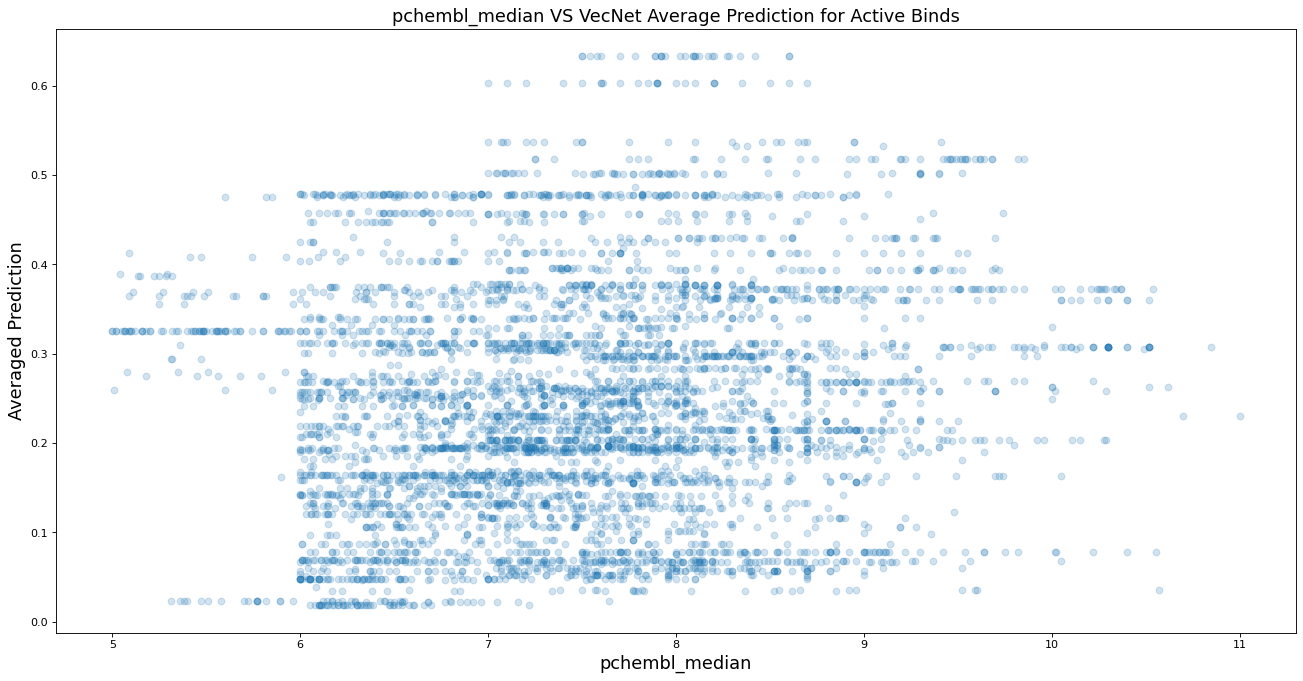

In [78]:
figure(figsize=(20, 10), dpi=80)
plt.title('pchembl_median VS VecNet Average Prediction for Active Binds',fontsize=16)
plt.scatter(chembl_all[chembl_all['Y']==1]['pchembl_median'],chembl_all[chembl_all['Y']==1]['Averaged Predictions'],alpha=0.2)
plt.xlabel('pchembl_median',fontsize=16)
plt.ylabel('Averaged Prediction',fontsize=16)
plt.show()

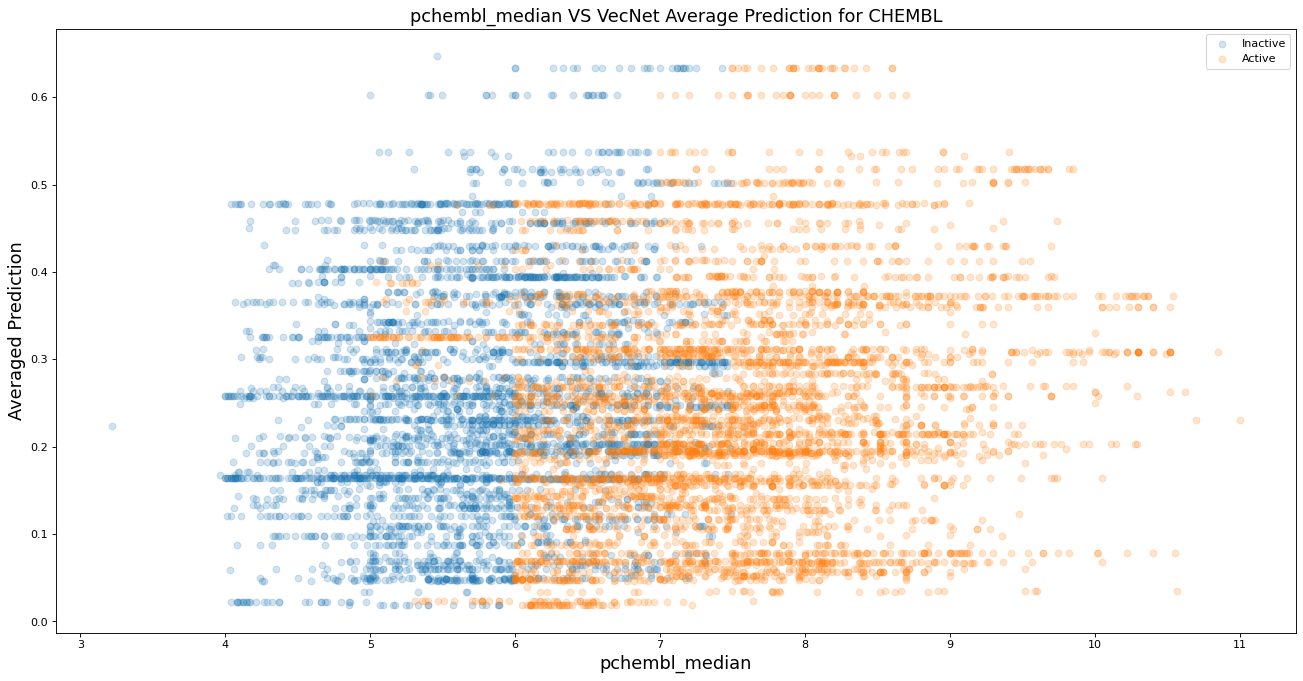

In [79]:
figure(figsize=(20, 10), dpi=80)
plt.title('pchembl_median VS VecNet Average Prediction for CHEMBL',fontsize=16)
plt.scatter(chembl_all[chembl_all['Y']==0]['pchembl_median'],chembl_all[chembl_all['Y']==0]['Averaged Predictions'],alpha=0.2,label='Inactive')
plt.scatter(chembl_all[chembl_all['Y']==1]['pchembl_median'],chembl_all[chembl_all['Y']==1]['Averaged Predictions'],alpha=0.2,label='Active')
plt.xlabel('pchembl_median',fontsize=16)
plt.ylabel('Averaged Prediction',fontsize=16)
plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.show()